## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

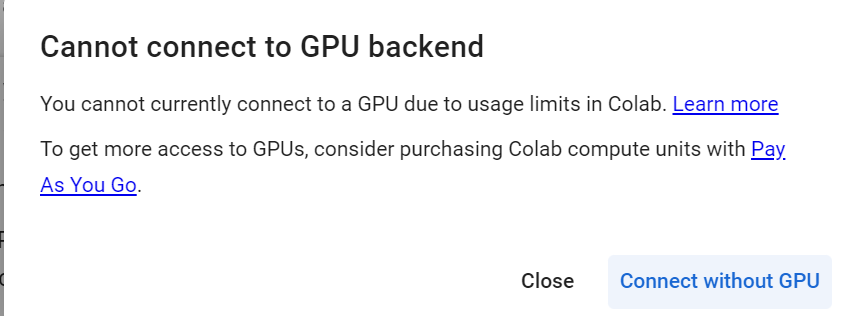

## **Installing and Importing Necessary Libraries**

In [1]:
#included this line to elimate the gensim and numpy dependency and version issues
!pip install --upgrade pip -q

In [2]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

restart the session and execute the above 2 lines to eliminate the numpy error dependencies.

In [3]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To encode the target variable
from sklearn.preprocessing import LabelEncoder

# Patching scipy.linalg before importing gensim
import scipy.linalg    # Import scipy.linalg
from numpy import triu    # Import triu from numpy
scipy.linalg.triu = triu    # Inject triu into scipy.linalg

# To import Word2Vec
from gensim.models import Word2Vec

import sklearn.metrics as metrics
# To tune the model
from sklearn.model_selection import GridSearchCV

# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer

# To split data into train and test sets
from sklearn.model_selection import train_test_split

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# To compute metrics to evaluate the model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Loading the dataset**

In [4]:
# mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# loading the dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/Project/stock_news.csv')

In [6]:
data = df.copy()

## **Data Overview**

In [7]:
data.head()

Date  \
0  2019-01-02   
1  2019-01-02   
2  2019-01-02   
3  2019-01-02   
4  2019-01-02   

                                                                                                                                                                                                                                                                                                                                   News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   
4                      Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets   

        Open       High        Low      Close     Volume  Label  
0  41.740002  42.244999  41.482498  40.246914  130672400     -1  
1  41.740002  42.244999  41.482498  40.246914  130672400     -1  
2  41.740002  42.244999  41.482498  40.246914  130672400     -1  
3  41.740002  42.244999  41.482498  40.246914  130672400     -1  
4  41.740002  42.244999  41.482498  40.246914  130672400     -1

In [8]:
# checking a stock news
data.loc[3, 'News']

' This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple'

In [9]:
data.shape

(349, 8)

Observation : There are 349 rows and 8 columns.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


Observations:
  - There are 6 numerical columns and 2 object columns.
  - We need to convert Date column which is object type to date type

In [11]:
# changing the data type of Date column
data['Date'] = pd.to_datetime(data['Date'])

In [12]:
#verify Date column after converting to datetime type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


Observations:
   - We see that the Date column is converted to datetime type.
   - There are 6 numerical columns, 1 datetime column and 1 object column.

In [13]:
data.describe().T

count                           mean                  min  \
Date      349  2019-02-16 16:05:30.085959936  2019-01-02 00:00:00   
Open    349.0                      46.229233            37.567501   
High    349.0                      46.700458            37.817501   
Low     349.0                      45.745394               37.305   
Close   349.0                      44.926317            36.254131   
Volume  349.0               128948236.103152           45448000.0   
Label   349.0                      -0.054441                 -1.0   

                        25%                  50%                  75%  \
Date    2019-01-14 00:00:00  2019-02-05 00:00:00  2019-03-22 00:00:00   
Open              41.740002            45.974998              50.7075   
High              42.244999            46.025002            50.849998   
Low               41.482498            45.639999              49.7775   
Close             40.246914            44.596924             49.11079   
Volume          103272000.0          115627200.0          151125200.0   
Label                  -1.0                  0.0                  0.0   

                        max              std  
Date    2019-04-30 00:00:00              NaN  
Open              66.817497         6.442817  
High                67.0625         6.507321  
Low               65.862503         6.391976  
Close             64.805229         6.398338  
Volume          244439200.0  43170314.918964  
Label                   1.0         0.715119

Observations:
  - Open: Mean Open price is 46.22 dollars, min price is 37.56 dollars and max price is 66.81 dollars.
  - High: Mean High price is 46.70 dollars, min price is 37.81 dollars and max price is 67.06 dollars.
  - Low: Mean Low price is 45.74 dollars,min price is 37.30 dollars and max price is 65.86 dollars.
  - Volume: Mean Volume is 128948236, min Volume is 45448000 and max Volume is 244439200.

In [14]:
#check for null values
data.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

Observations:
  - There are no null values.

In [15]:
#check for duplicates
data.duplicated().sum()

0

Observations:
  - There are no duplicates.

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

**Label**

In [16]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        legend=False,
        hue=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

**Distribution of Sentiments**

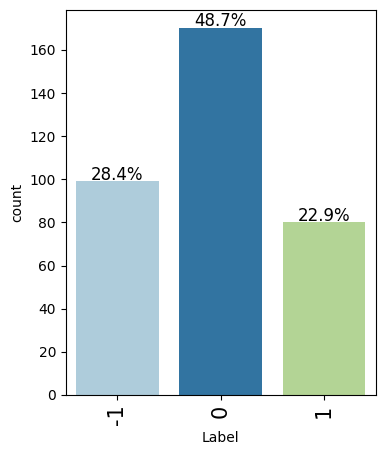

In [17]:
labeled_barplot(data, "Label", perc=True)

Observations:
 - Class 0 (Neutral): 48.7% is neutral sentiment and is the majority class
 - Class -1(Negative): 28.4% is negative sentiment and is the second highest class.
 - Class 1(Positive): 22.9% is positive sentiment and is the class with the least count.

 We see that the data is imbalanced.

**Open Price**

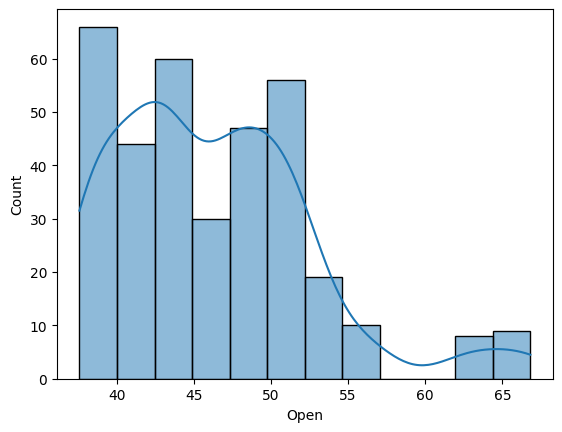

In [18]:
sns.histplot(data['Open'],kde=True)
plt.show()

Observations:
  - Open price is right skewed distribution.

In [19]:
#calculate the mode
data['Open'].mode()

0    43.57
Name: Open, dtype: float64

Observations:
 - Mean Open price(46.22) > Median Open price(45.97) > Mode Open price(43.57)

In [20]:
# Creating a time series DataFrame with 'Date' as index
timeseries_df = data.set_index('Date')

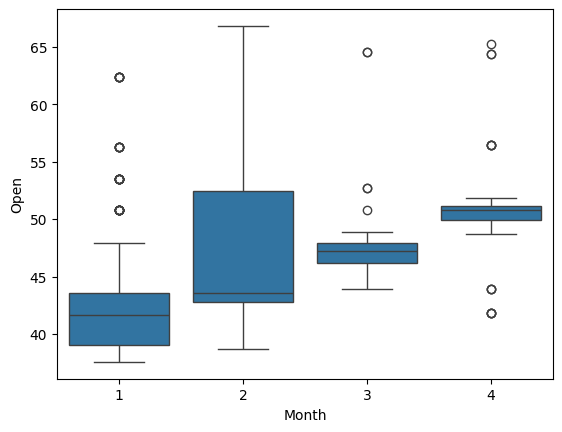

In [21]:
timeseries_df['Month'] = timeseries_df.index.month  # Extract month from the index
sns.boxplot(x='Month', y='Open', data=timeseries_df)  # Box plot of 'Close' prices by month
plt.show()

Observations:
  - There are outliers in Month 1, 3 and 4.
  - Month 2 Open price has the wide range of prices.

**High Price**

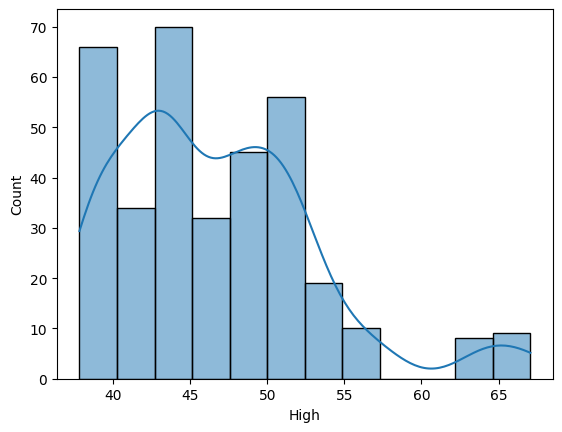

In [22]:
sns.histplot(data['High'],kde=True)
plt.show()

Observations:
  - High stock price is right skewed distribution.

In [23]:
#calculate the mode of High stock price
data['High'].mode()

0    43.787498
Name: High, dtype: float64

Observations:
  - Mean High price(46.70) > Median High price(46.02) > Mode High price(43.78)

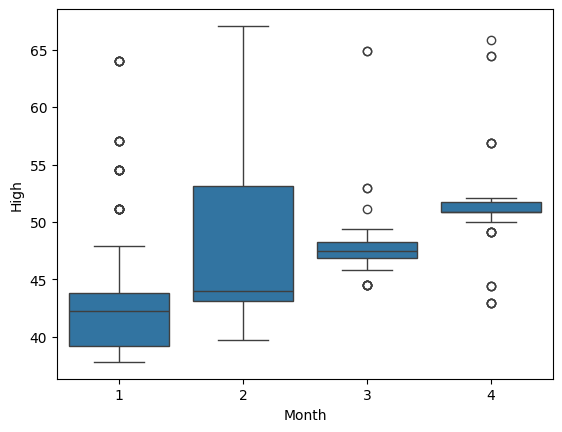

In [24]:
timeseries_df['Month'] = timeseries_df.index.month  # Extract month from the index
sns.boxplot(x='Month', y='High', data=timeseries_df)  # Box plot of 'Close' prices by month
plt.show()

Observations:
  - There are outliers in month 1, 3 and 4.
  - Month 2 Open price has the wide range of prices.

**Low Price**

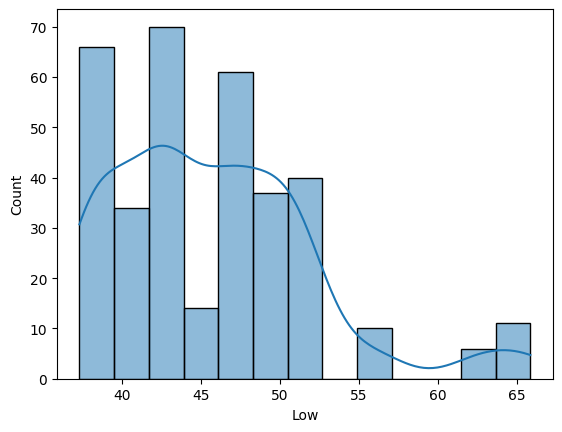

In [25]:
sns.histplot(data['Low'],kde=True)
plt.show()

Observations:

Low stock price is right skewed distribution.

In [26]:
#calculate the mode of Low stock price
data['Low'].mode()

0    43.2225
Name: Low, dtype: float64

Observations:
  - Mean Low Price(45.74)>Median Low Price(45.63)>Mode Low Price(43.22)

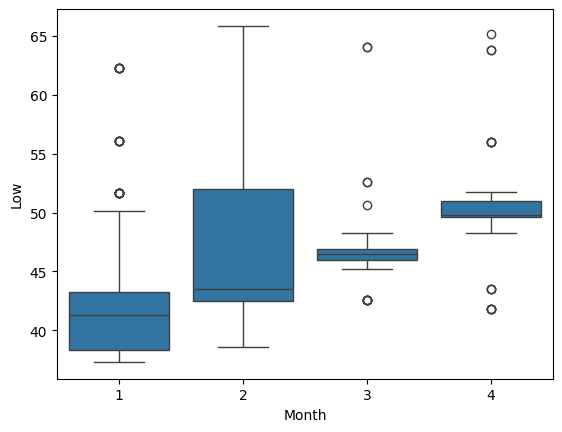

In [27]:
timeseries_df['Month'] = timeseries_df.index.month  # Extract month from the index
sns.boxplot(x='Month', y='Low', data=timeseries_df)  # Box plot of 'Close' prices by month
plt.show()

Observations:
  - There are outliers in month 1, 3 and 4.
  - Month 2 Low price has the wide range of prices.

**Close Price**

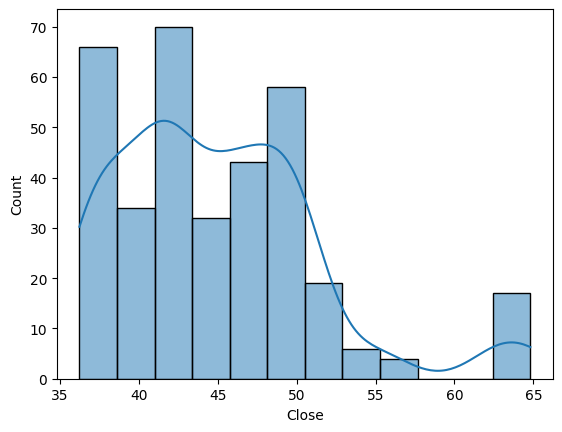

In [28]:
sns.histplot(data['Close'],kde=True)
plt.show()

Observations:
  - Its a right skewed distribution.

In [29]:
#calculate the mode
data['Close'].mode()

0    42.470604
Name: Close, dtype: float64

Observations:
  - Mean Close price(44.92) > Median Close price(44.59) > Mode Close price(42.47)

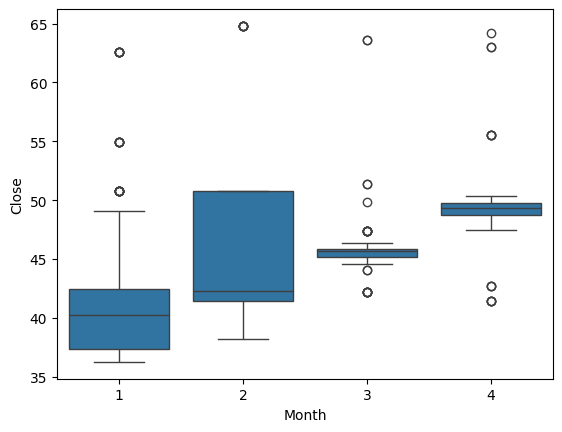

In [30]:
timeseries_df['Month'] = timeseries_df.index.month  # Extract month from the index
sns.boxplot(x='Month', y='Close', data=timeseries_df)  # Box plot of 'Close' prices by month
plt.show()

Observations:
  - There are outliers in all the months.
  

**Volume**

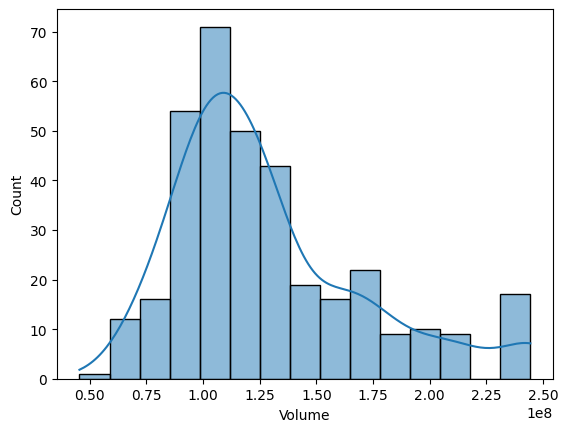

In [31]:
sns.histplot(data['Volume'],kde=True)
plt.show()

Observations:
  - Volume is a right skewed distribution.

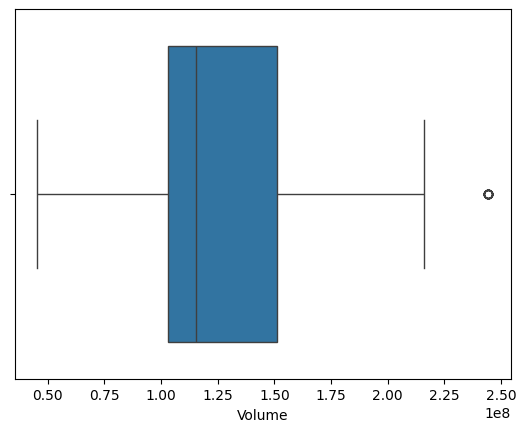

In [32]:
sns.boxplot(x=data['Volume'])
plt.show()

Observations:
  - There is outlier.

**Compute and check the distribution of the length of news content**

In [33]:
#calculate the length of each news article
data['news_length'] = data['News'].apply(len)

In [34]:
#check the newly added column 'news_length'
data.head()

Date  \
0 2019-01-02   
1 2019-01-02   
2 2019-01-02   
3 2019-01-02   
4 2019-01-02   

                                                                                                                                                                                                                                                                                                                                   News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   
4                      Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets   

        Open       High        Low      Close     Volume  Label  news_length  
0  41.740002  42.244999  41.482498  40.246914  130672400     -1          324  
1  41.740002  42.244999  41.482498  40.246914  130672400     -1          323  
2  41.740002  42.244999  41.482498  40.246914  130672400     -1          296  
3  41.740002  42.244999  41.482498  40.246914  130672400     -1          300  
4  41.740002  42.244999  41.482498  40.246914  130672400     -1          305

**Check the distribution**

**Histogram**

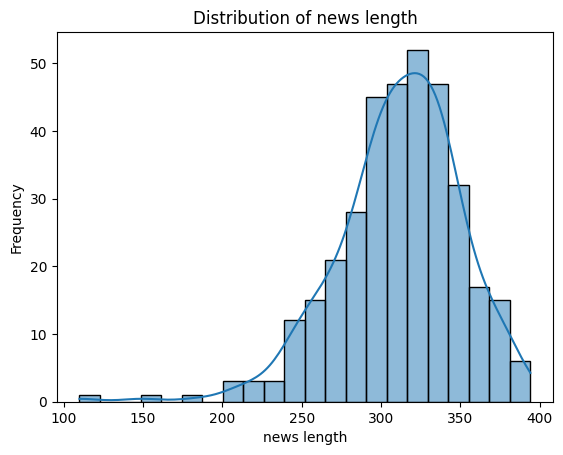

In [35]:
sns.histplot(data['news_length'], kde=True)
plt.xlabel('news length')
plt.ylabel('Frequency')
plt.title('Distribution of news length')
plt.show()

Observations:
  - Its a left skewed distribution.

In [36]:
print(data['news_length'].describe())

count    349.000000
mean     311.237822
std       39.079467
min      110.000000
25%      290.000000
50%      315.000000
75%      336.000000
max      394.000000
Name: news_length, dtype: float64


Observations:
  - Mean news length is 311 characters. Min is 110 characters and max is 394 characters.

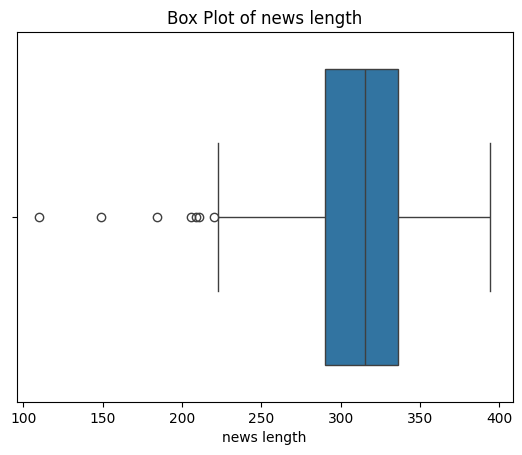

In [37]:
sns.boxplot(x=data['news_length'])
plt.xlabel('news length')
plt.title('Box Plot of news length')
plt.show()

Observations:
  - There are outliers in news length.

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

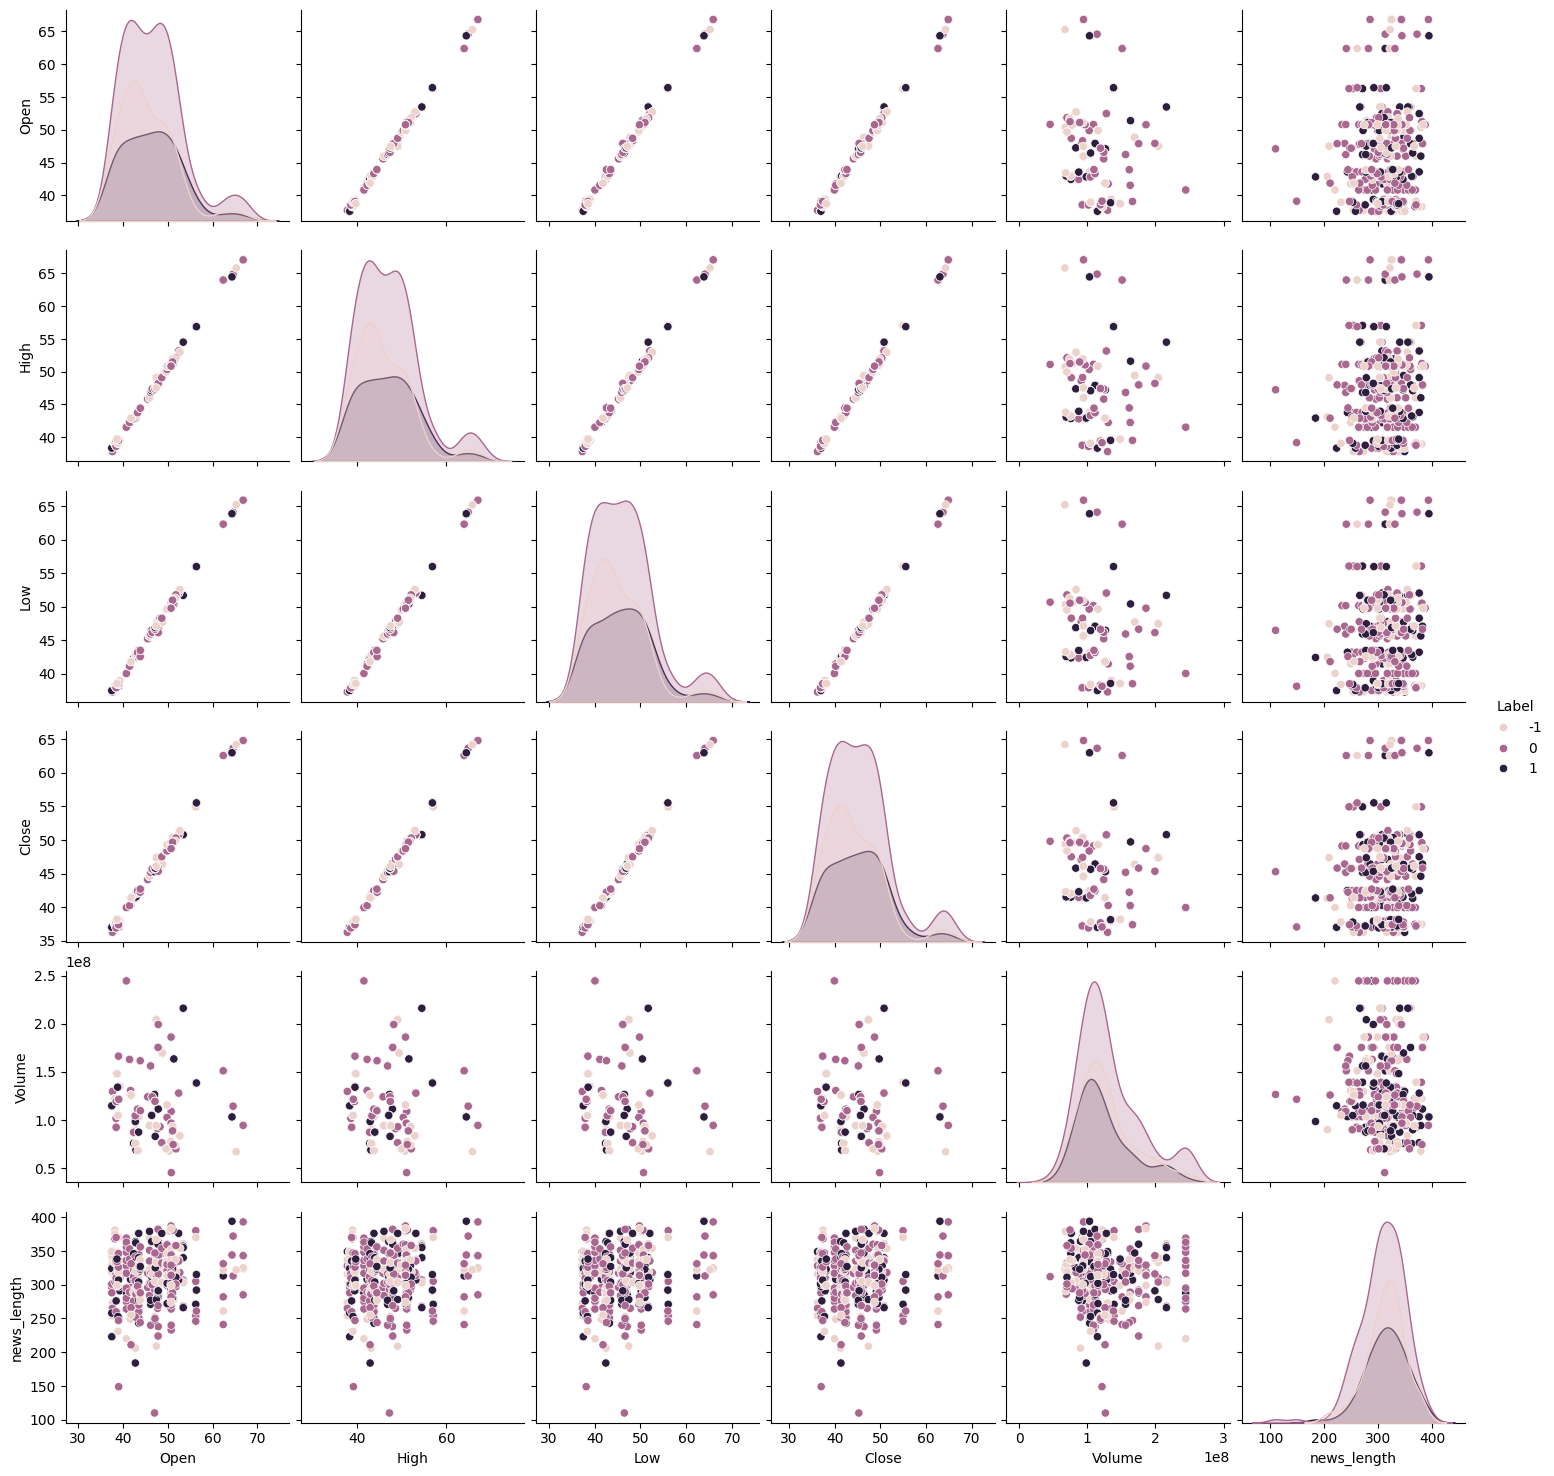

In [38]:
sns.pairplot(data=data,hue='Label')

Observations:
 - We see a positive correlation between
     - Open price and High price
     - Open price and Low price
     - Open price and Close price
     - High Price and Low Price
     - High Price and Close Price
     - Low Price and Close Price

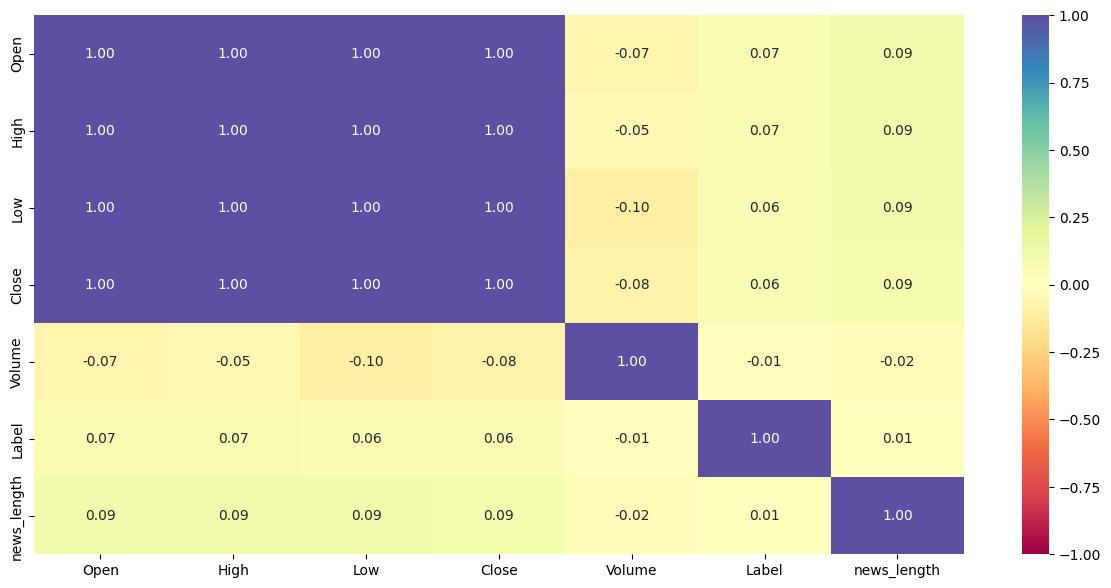

In [39]:
plt.figure(figsize=(15, 7))
numeric_df = data.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Observations:
  - We see the highest positive correlation of 1.0 between the following
     - Open price and High price
     - Open price and Low price
     - Open price and Close price
     - High Price and Low Price
     - High Price and Close Price
     - Low Price and Close Price

### Relationship of numerical variables on target variable

* Sentiment Polarity vs Price
    * Sentiment polarity vs Open
    * Sentiment polarity vs High
    * Sentiment polarity vs Low
    * Sentiment polarity vs Close


* Sentiment Polarity vs Volume

In [40]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 3, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[0, 2].set_title("Distribution of target for target=" + str(target_uniq[2]))
    sns.histplot(
        data=data[data[target] == target_uniq[2]],
        x=predictor,
        kde=True,
        ax=axs[0, 2],
        color="blue",
    )
    axs[1, 0].set_title("Boxplot w.r.t target")
    #sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")
    sns.boxplot(data=data, x=target, y=predictor, hue=target, ax=axs[1, 0], palette="gist_rainbow", legend=False)

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        hue=target,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
        legend=False
    )

    plt.tight_layout()
    plt.show()

**Sentimental Polarity(Label) vs Open Price**

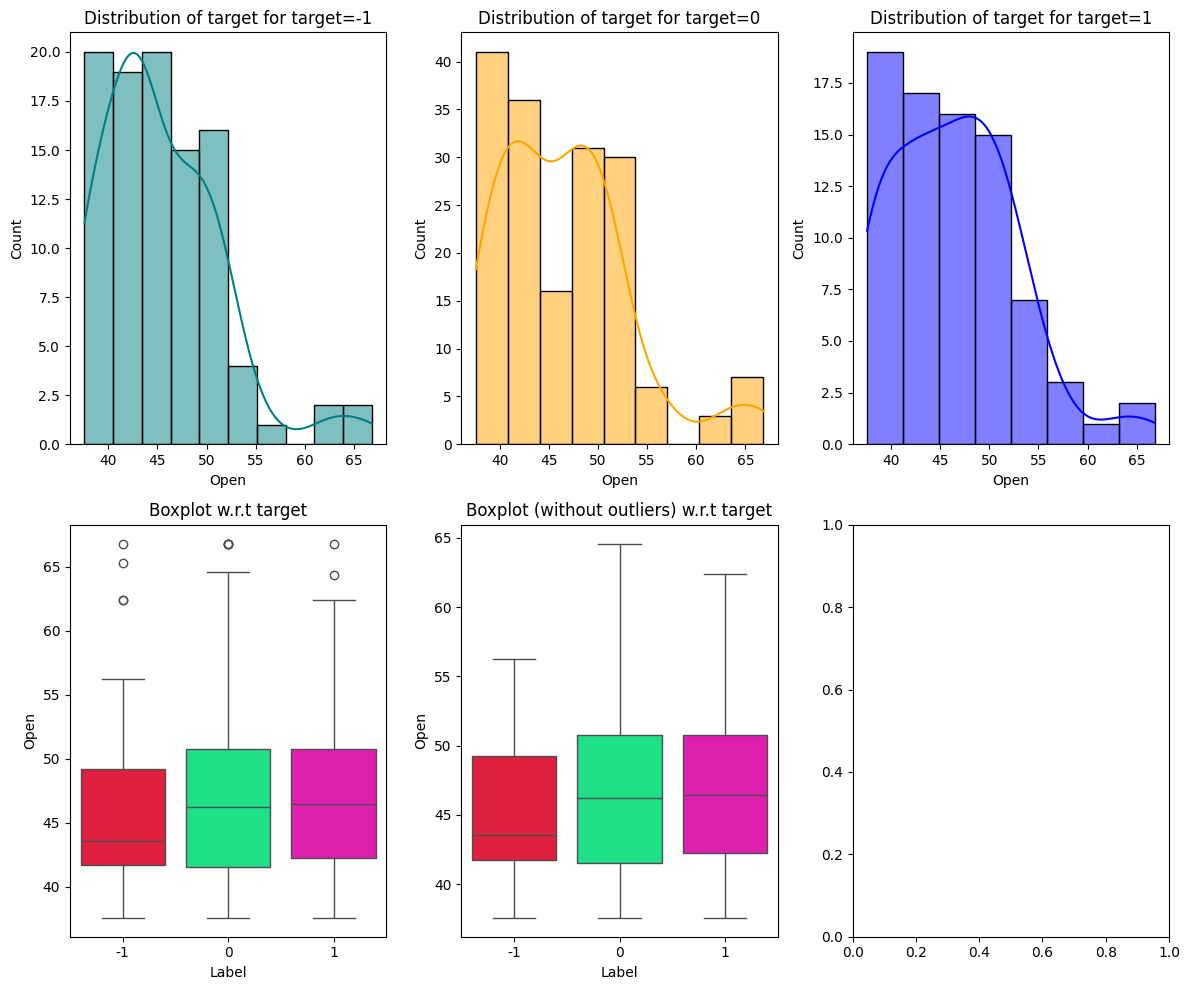

In [41]:
distribution_plot_wrt_target(data, 'Open', 'Label')

Observations:
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median Open price of neutral and positive is around 47 and negative sentiment is less which is around 43.

**Sentimental Polarity(Label) vs High Price**

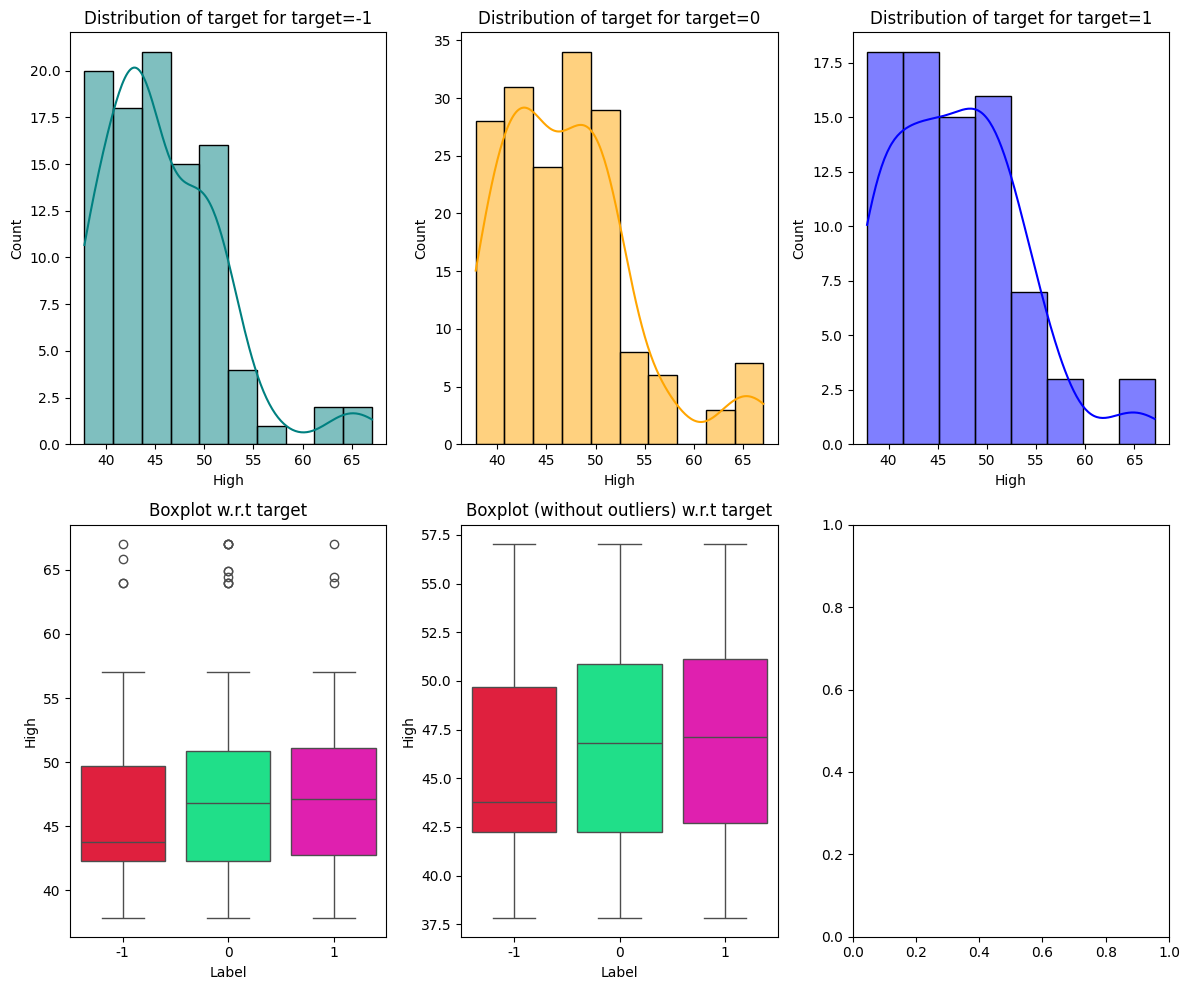

In [42]:
distribution_plot_wrt_target(data, 'High', 'Label')

Observations:
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median High price of neutral and positive is around 47 and negative sentiment is less which is around 43.

**Sentimental Polarity(Label) vs Low Price**

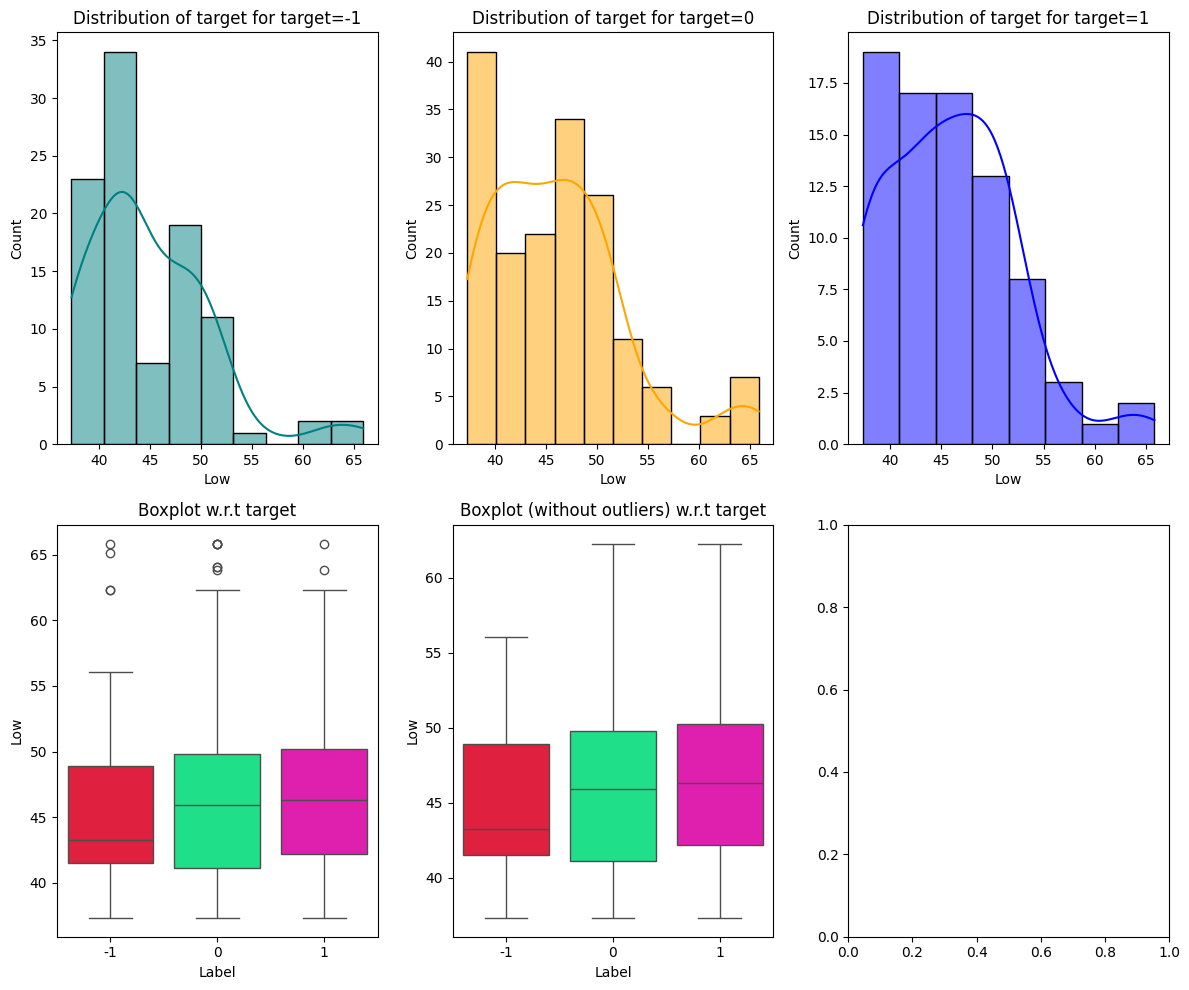

In [43]:
distribution_plot_wrt_target(data, 'Low', 'Label')

Observations:
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median Open price of neutral and positive is around 47 and negative sentiment is less which is around 43.

**Sentimental Polarity(Label) vs Close Price**

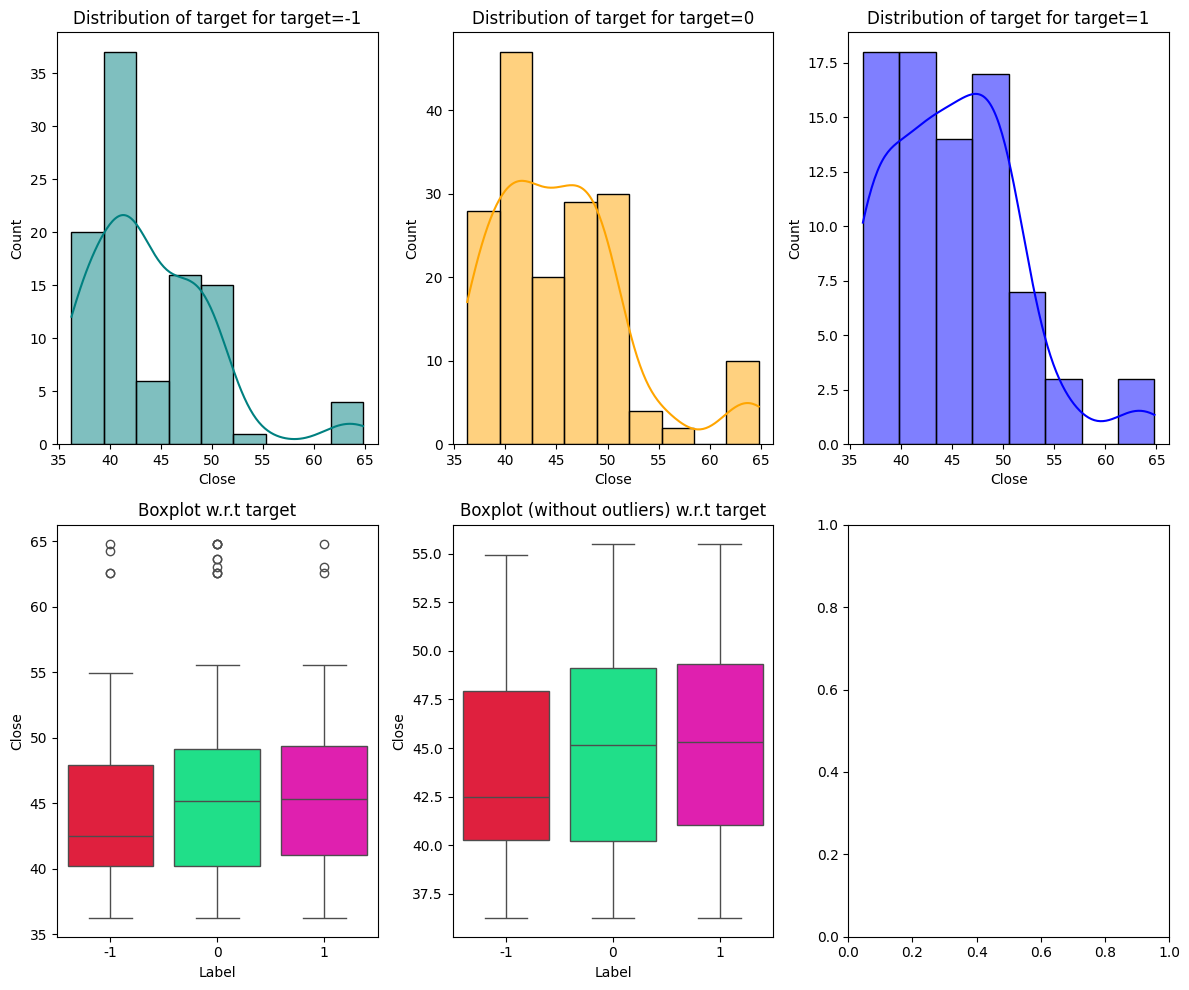

In [44]:
distribution_plot_wrt_target(data, 'Close', 'Label')

Observations:
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median Close price of neutral and positive is around 45 and negative sentiment is less which is around 42.

**Sentimental Polarity(Label) vs Volume**

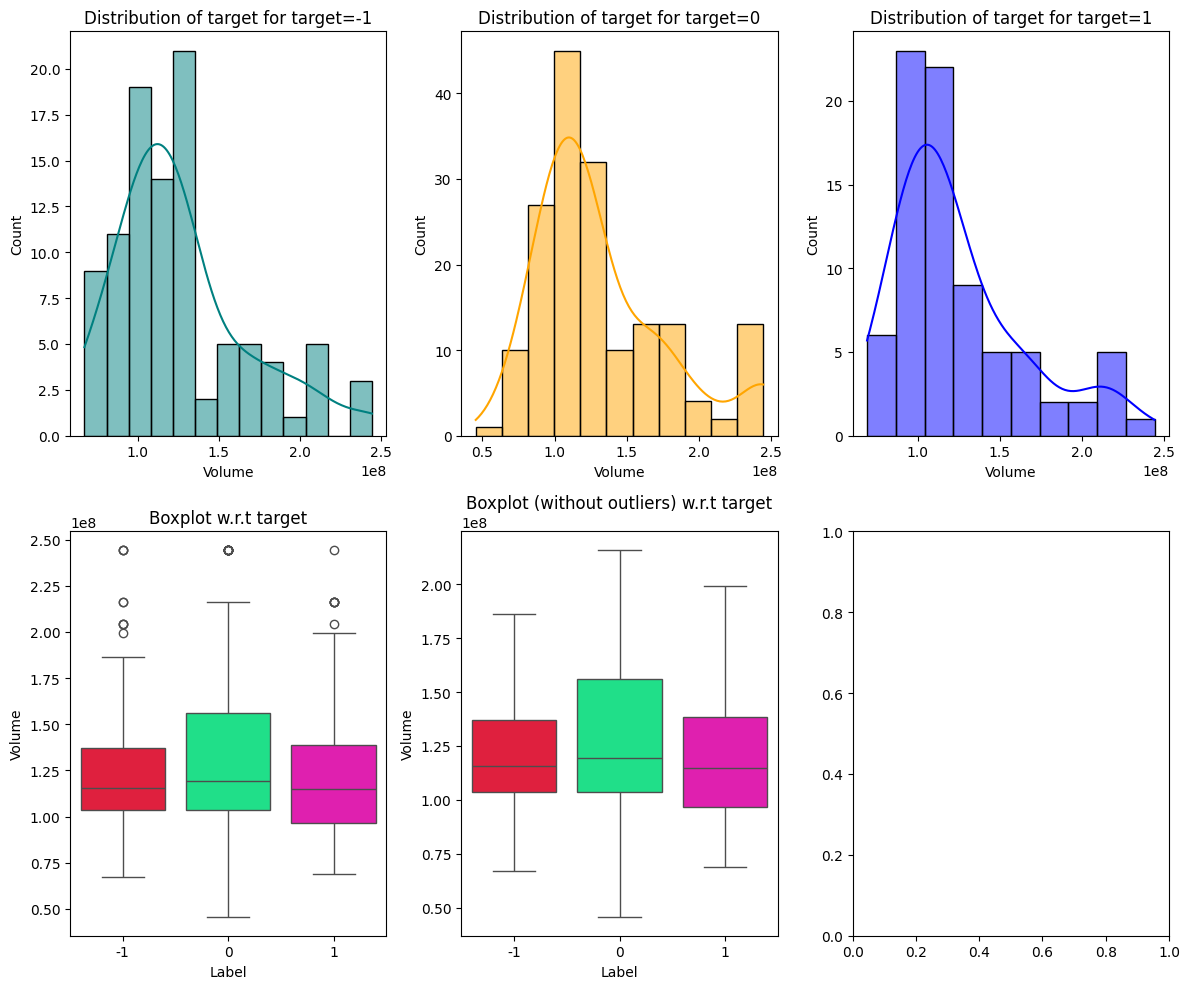

In [45]:
distribution_plot_wrt_target(data, 'Volume', 'Label')

Observations:
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median Volume of neutral sentiment is around 1.20x10^8, negative sentiment is around 1.125x10^8, positive sentiment is around 1.15x10^8.
  

**Price vs Date**

**Plot Open,High,Low and Close Prices Vs Date**

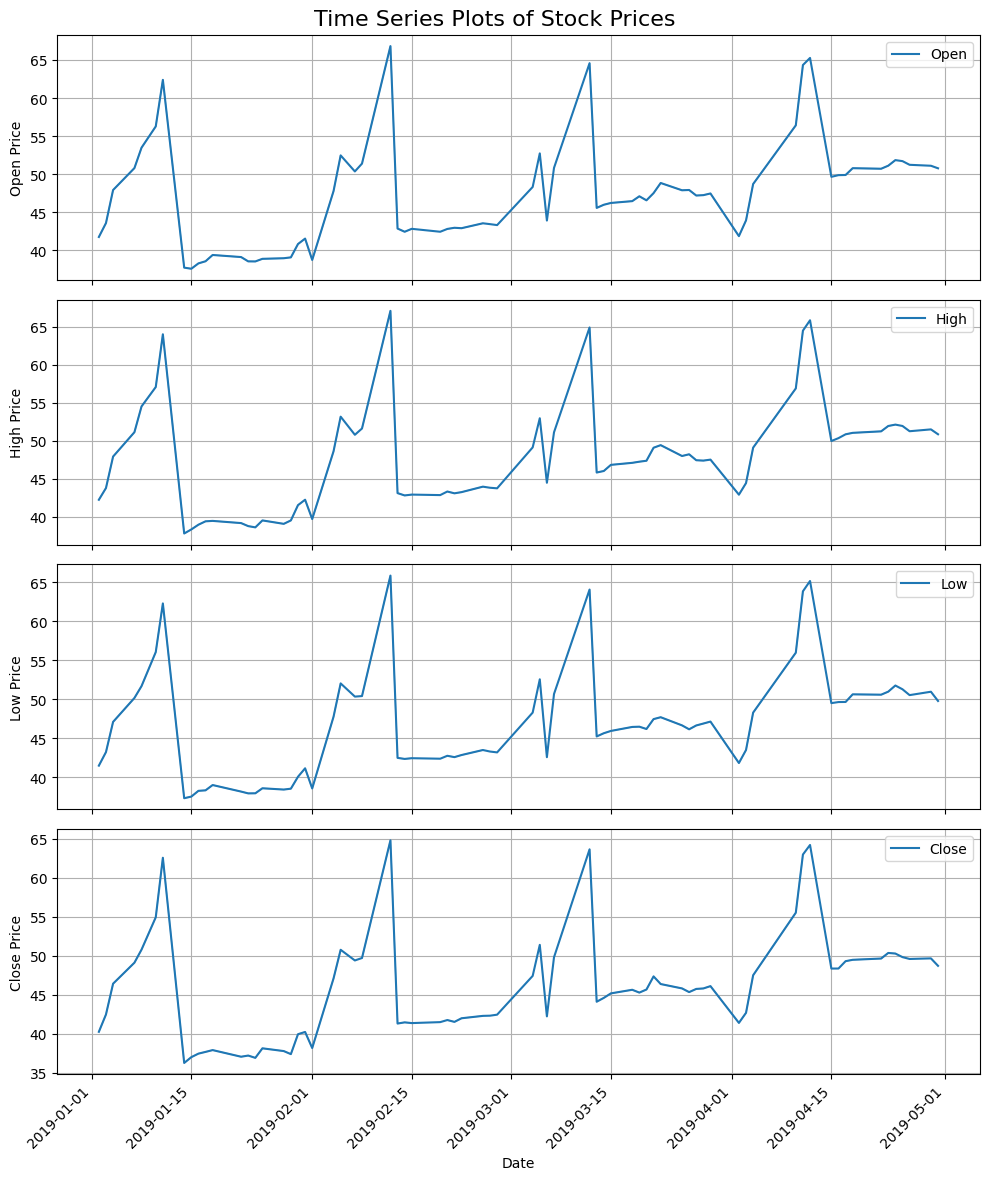

In [46]:
#build timeseries plot
# Create subplots
fig,axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)  # 4 rows, 1 column

# Plot each price on a separate subplot
sns.lineplot(x=timeseries_df.index, y=timeseries_df['Open'], label='Open', ax=axes[0])
sns.lineplot(x=timeseries_df.index, y=timeseries_df['High'], label='High', ax=axes[1])
sns.lineplot(x=timeseries_df.index, y=timeseries_df['Low'], label='Low', ax=axes[2])
sns.lineplot(x=timeseries_df.index, y=timeseries_df['Close'], label='Close', ax=axes[3])
# Add labels and titles
for ax, price_type in zip(axes, ['Open', 'High', 'Low', 'Close']):
    ax.set_ylabel(price_type + ' Price')
    ax.legend()
    ax.grid(True)

axes[3].set_xlabel('Date')  # X-axis label only on the bottom subplot
fig.suptitle('Time Series Plots of Stock Prices', fontsize=16)  # Overall title

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()  # Adjust spacing
plt.show()  # Display the plot

Observations:
  - The graph pattern of Open,High, Low and Close price looks very similar over the period of time.
  - The stock price trend
      - begins to rise up from begining of the month, peaks before the mid of the month, the drops low by mid of the month.It stays low from mid of the month to the beginning of the next month and the cycle continues.
      - The above cycle is true for all stock prices - Open, High, Low and Close price.
  - The stock price range across all the prices are very similar.



**Volume vs Date**

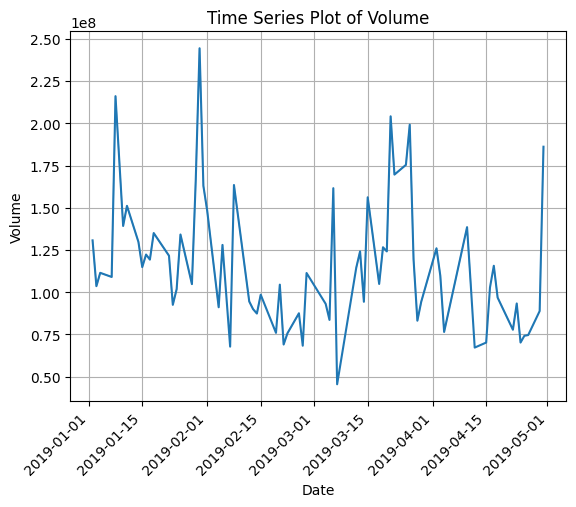

In [47]:
#plot Volume vs date
sns.lineplot(x='Date', y='Volume', data=timeseries_df)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Time Series Plot of Volume')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

Observations:
  - Highest volume traded is around 2019-02-1 and lowest volume traded is between 2019-03-01 and 2019-03-15.

**Volume of stocks traded every month**

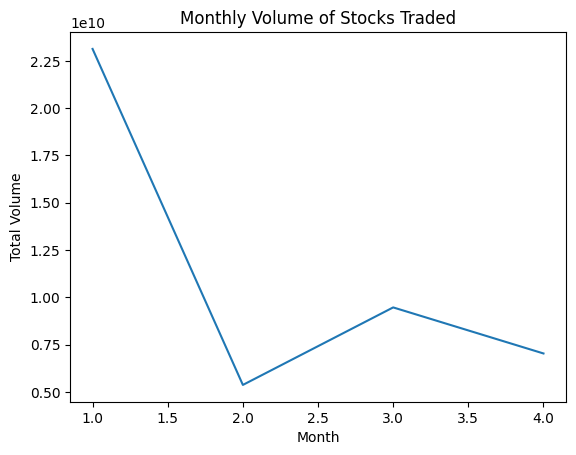

In [48]:
#Volume of stocks traded every month
timeseries_df['Month'] = timeseries_df.index.month
monthly_volume = timeseries_df.groupby('Month')['Volume'].sum()
sns.lineplot(x= monthly_volume.index, y=monthly_volume.values)
plt.xlabel('Month')
plt.ylabel('Total Volume')
plt.title('Monthly Volume of Stocks Traded')
plt.show()

Observations:
 - Volume decreases significantly after month 1,it drops to 0.50x10^10 by month 2, it then raises to 1.00x10^10 by month 3 and drops to 0.75x10^10 by month 4

###Price, Volume vs date

Plot Price and Volume in y axis and date on x axis to see how the change in price and Volume over a period of time happens and if there is a pattern.

**Open Price, Volume vs date**

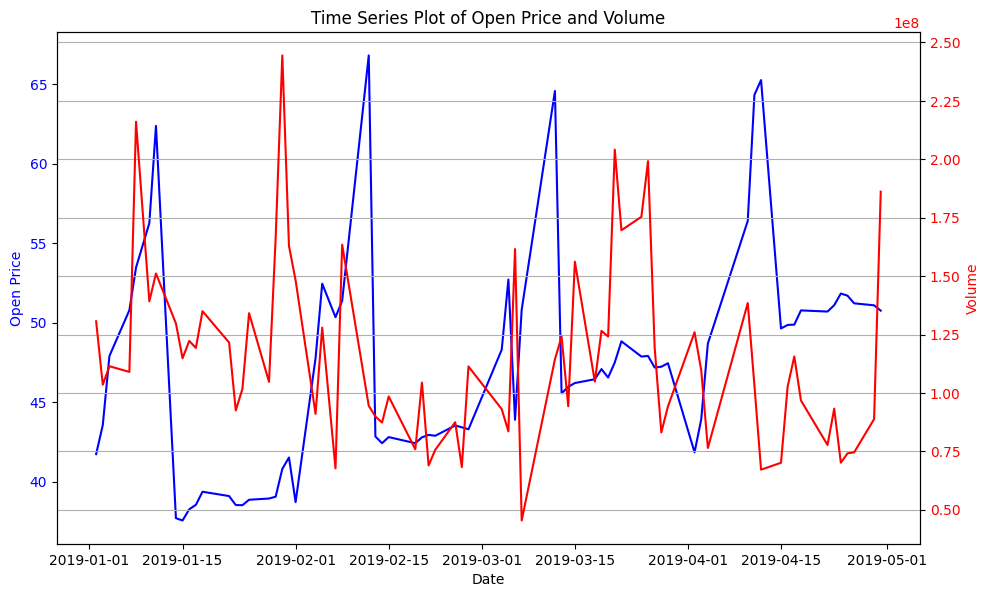

In [49]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(timeseries_df.index, timeseries_df['Open'], color='blue', label='Open Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(timeseries_df.index, timeseries_df['Volume'], color='red', label='Volume')
ax2.set_ylabel('Volume', color='red')
ax2.tick_params('y', labelcolor='red')

fig.tight_layout()
plt.title('Time Series Plot of Open Price and Volume')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

Observations:
  - Changing trend in Volume and open price is not correlated.
  - Open Price and Volume peaks at different times.

**High Price, Volume vs date**

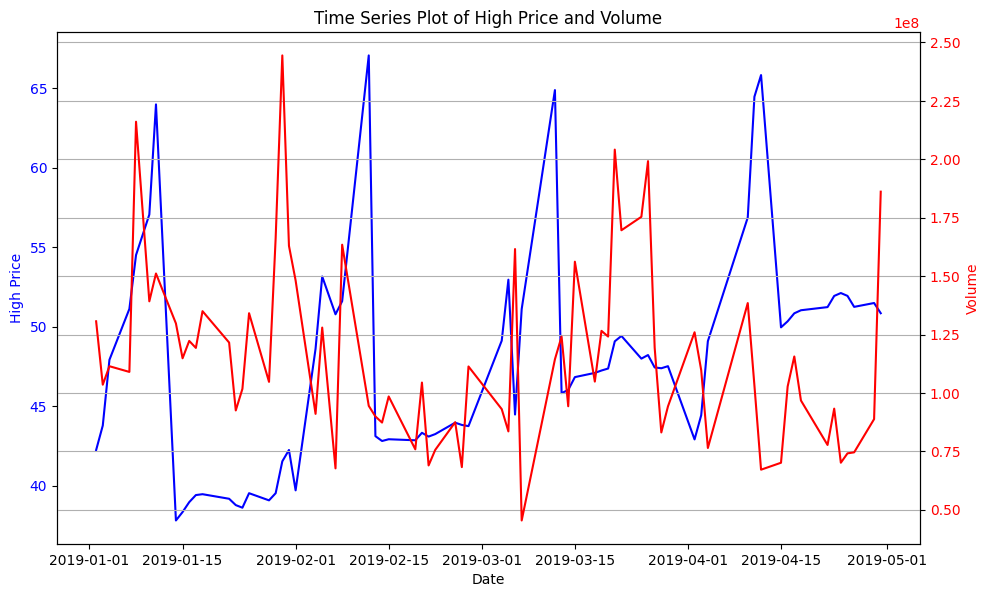

In [50]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(timeseries_df.index, timeseries_df['High'], color='blue', label='High Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('High Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(timeseries_df.index, timeseries_df['Volume'], color='red', label='Volume')
ax2.set_ylabel('Volume', color='red')
ax2.tick_params('y', labelcolor='red')

fig.tight_layout()
plt.title('Time Series Plot of High Price and Volume')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

Observations:
  - Changing trend in Volume and High price is not correlated.
  - Open Price and Volume peaks at different times.

**Low Price, Volume vs date**

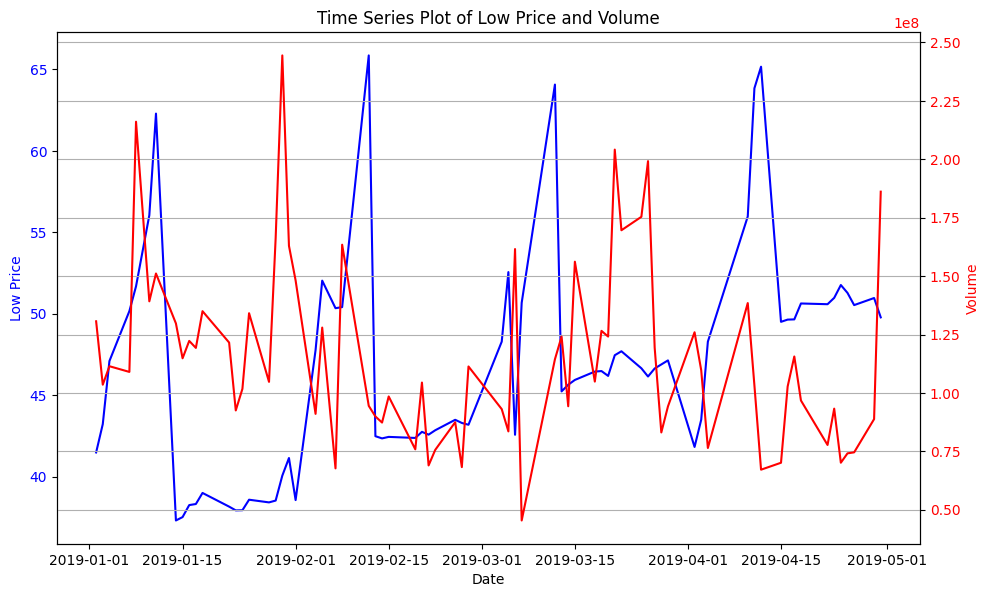

In [51]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(timeseries_df.index, timeseries_df['Low'], color='blue', label='Low Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Low Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(timeseries_df.index, timeseries_df['Volume'], color='red', label='Volume')
ax2.set_ylabel('Volume', color='red')
ax2.tick_params('y', labelcolor='red')

fig.tight_layout()
plt.title('Time Series Plot of Low Price and Volume')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

Observations:
  - Changing trend in Volume and Low price is not correlated.
  - Open Price and Volume peaks at different times.

**Close Price, Volume vs date**

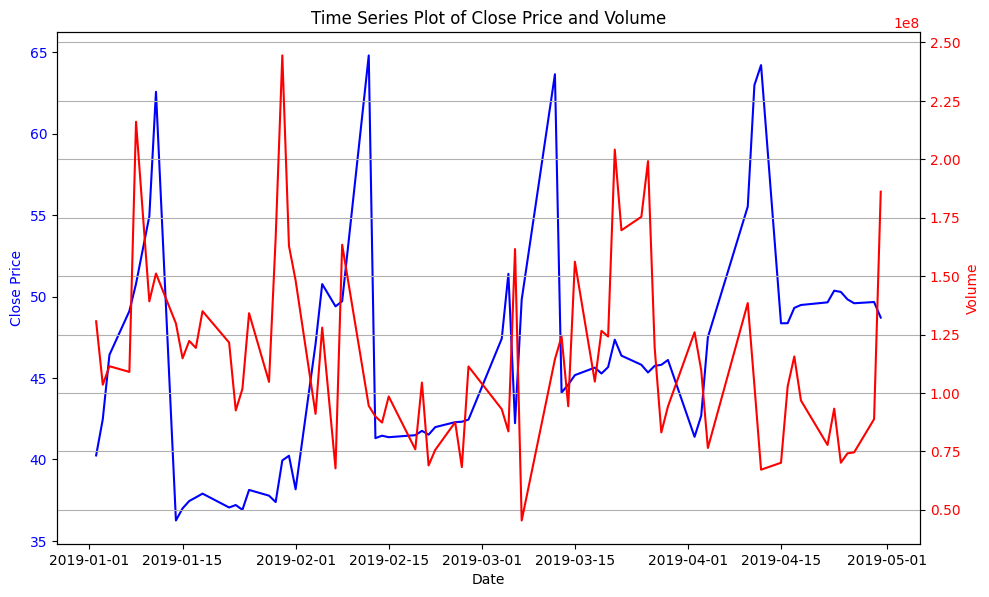

In [52]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(timeseries_df.index, timeseries_df['Close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params('y', labelcolor='blue')

ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(timeseries_df.index, timeseries_df['Volume'], color='red', label='Volume')
ax2.set_ylabel('Volume', color='red')
ax2.tick_params('y', labelcolor='red')

fig.tight_layout()
plt.title('Time Series Plot of Close Price and Volume')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

Observations:
  - Changing trend in Volume and Close price is not correlated.
  - Open Price and Volume peaks at different times.

### **EDA Summary**

Univariate Analysis

- Class 0 (Neutral): 48.7% is neutral sentiment and is the majority class
- Class -1(Negative): 28.4% is negative sentiment and is the second highest class.
- Class 1(Positive): 22.9% is positive sentiment and is the class with the least count. We see that the data is imbalanced.

Multivariate Analysis

- Sentimental Polarity(Label) vs Open Price
    - Distribution is left skewed for negative,neutral and positive sentiments.
    - There are outliers for all the sentiments.
    - Median Open price of neutral and positive is around 47 and negative sentiment is less which is around 43.

- Sentimental Polarity(Label) vs High Price
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median High price of neutral and positive is around 47 and negative sentiment is less which is around 43.

- Sentimental Polarity(Label) vs Low Price
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median Open price of neutral and positive is around 47 and negative sentiment is less which is around 43.


- Sentimental Polarity(Label) vs Close Price
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median Close price of neutral and positive is around 45 and negative sentiment is less which is around 42.

- Sentimental Polarity(Label) vs Volume
  - Distribution is left skewed for negative,neutral and positive sentiments.
  - There are outliers for all the sentiments.
  - Median Volume of neutral sentiment is around 1.20x10^8, negative sentiment is around 1.125x10^8, positive sentiment is around 1.15x10^8.
  
- Price vs Date
   - The graph pattern of Open,High, Low and Close price looks very similar over the period of time.
   - The stock price trend
       - begins to rise up from begining of the month, peaks before the mid of the month, the drops low by mid of the month.It stays low from mid of the month to the beginning of the next month and the cycle continues.
       - The above cycle is true for all stock prices - Open, High, Low and Close price.
   - The stock price range across all the prices are very similar.

- Volume of stocks traded every month

    - Volume decreases significantly after month 1,it drops to 0.50x10^10 by month 2, it then raises to 1.00x10^10 by month 3 and drops to 0.75x10^10 by month 4.


## **Data Preprocessing**

In [53]:
dataset = data.copy()

###Preprocessing the textual column

In [54]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [55]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    text = ' '.join([word for word in words if word not in stopwords.words('english')])

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    text = ' '.join([ps.stem(word) for word in words])

    return text

In [56]:
# preprocessing the textual column
dataset['News_clean'] = dataset['News'].apply(preprocess_text)

In [57]:
#display cleaned text
dataset.head()

Date  \
0 2019-01-02   
1 2019-01-02   
2 2019-01-02   
3 2019-01-02   
4 2019-01-02   

                                                                                                                                                                                                                                                                                                                                   News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   
4                      Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets   

        Open       High        Low      Close     Volume  Label  news_length  \
0  41.740002  42.244999  41.482498  40.246914  130672400     -1          324   
1  41.740002  42.244999  41.482498  40.246914  130672400     -1          323   
2  41.740002  42.244999  41.482498  40.246914  130672400     -1          296   
3  41.740002  42.244999  41.482498  40.246914  130672400     -1          300   
4  41.740002  42.244999  41.482498  40.246914  130672400     -1          305   

                                                                                                                                                                                                                                                                        News_clean  
0  the tech sector experienc a signific declin in the aftermarket follow appl q revenu warn notabl supplier includ skywork broadcom lumentum qorvo and tsmc saw their stock drop in respons to appl downward revis of it revenu expect for the quarter previous announc in januari  
1               appl lower it fiscal q revenu guidanc to billion from earlier estim of billion due to weaker than expect iphon sale the announc caus a signific drop in appl stock price and neg impact relat supplier lead to broader market declin for tech indic such as nasdaq  
2                  appl cut it fiscal first quarter revenu forecast from billion to billion due to weaker demand in china and fewer iphon upgrad ceo tim cook also mention constrain sale of airpod and macbook appl share fell in post market trade while asian supplier like hon  
3              thi news articl report that yield on longdat us treasuri secur hit their lowest level in nearli a year on januari due to concern about the health of the global economi follow weak econom data from china and europ as well as the partial us govern shutdown appl  
4                   appl revenu warn led to a declin in us

Please Note : Moved splitting the dataset after word embeddings

## **Word Embeddings**

### Word2Vec

In [58]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in dataset['News_clean'].values]

In [59]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [60]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2595


Let's check out a few word embeddings obtained using the model

In [61]:
# Checking the word embedding of a random word
word = "market"
model_W2V.wv[word]

array([-0.02619236,  0.10335973,  0.01207464,  0.02755376,  0.00298552,
       -0.18407145,  0.12158205,  0.38889915,  0.04796616, -0.03685791,
        0.02456207, -0.1171341 ,  0.02555677, -0.05101335, -0.11536811,
       -0.17199524,  0.05409845, -0.02532996,  0.09496446, -0.07704327,
       -0.04800744, -0.00629101,  0.10416293,  0.00923587,  0.08981215,
        0.02518637, -0.18417688,  0.04103204, -0.08342238, -0.14727788,
        0.00906451, -0.04796242,  0.02504796, -0.02937202, -0.03566457,
        0.0761544 ,  0.07735652, -0.18193936, -0.01028945,  0.01900533,
       -0.09667405,  0.02652544,  0.02958102, -0.11190179,  0.05965571,
        0.13110532,  0.07315437,  0.05403366, -0.03933836,  0.12233776,
        0.03553516,  0.00790851, -0.10131407, -0.00053939, -0.0209395 ,
        0.17489183,  0.08686557,  0.04414649,  0.09752031, -0.00081837,
       -0.09260087, -0.01635911, -0.00280022,  0.01870501, -0.02184183,
        0.10930146, -0.0349811 ,  0.02956992, -0.11956186, -0.06

In [62]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-0.02045205,  0.10463835,  0.01049446,  0.02802964,  0.00188161,
       -0.17688468,  0.11972414,  0.3783331 ,  0.04554815, -0.03532047,
        0.02425865, -0.1178901 ,  0.02426289, -0.0504083 , -0.11628226,
       -0.16344367,  0.05158539, -0.02283507,  0.08945501, -0.07324712,
       -0.0505218 , -0.01066491,  0.10034809,  0.00751636,  0.08666476,
        0.02326753, -0.17598642,  0.03907487, -0.08453679, -0.14542647,
        0.00849416, -0.0464244 ,  0.03064795, -0.03259274, -0.03925902,
        0.07780359,  0.07672428, -0.17327309, -0.01501076,  0.01965822,
       -0.09393512,  0.02784861,  0.03284603, -0.11282644,  0.06239362,
        0.1224938 ,  0.07322551,  0.05161165, -0.03844189,  0.11791036,
        0.03362389,  0.0088425 , -0.10191637, -0.00239066, -0.0185034 ,
        0.16622564,  0.08196869,  0.04112235,  0.0970806 , -0.00468619,
       -0.09072956, -0.01807338, -0.00292329,  0.02017715, -0.01744927,
        0.10350718, -0.03272745,  0.02909189, -0.11540888, -0.06

In [63]:
# Checking the word embedding of a random word
word = "analyst"
model_W2V.wv[word]

array([-0.01467016,  0.05792558,  0.00958164,  0.01494685,  0.00087817,
       -0.10193085,  0.06885614,  0.22184016,  0.02858982, -0.02007319,
        0.01562253, -0.0671638 ,  0.01015965, -0.03194374, -0.06489472,
       -0.09824303,  0.0320942 , -0.01624677,  0.0500955 , -0.04532096,
       -0.03032446, -0.00367097,  0.06326325,  0.00513419,  0.05316016,
        0.01258489, -0.10054068,  0.02463312, -0.04508311, -0.08145104,
        0.00983864, -0.02494508,  0.01676262, -0.01459704, -0.02279421,
        0.04286728,  0.04426806, -0.101835  , -0.00460594,  0.00779183,
       -0.05259016,  0.01437992,  0.02111489, -0.06423169,  0.0362953 ,
        0.07403231,  0.04477731,  0.02683544, -0.02113187,  0.06907009,
        0.02312756,  0.00560825, -0.05911102, -0.00085519, -0.01041416,
        0.0971791 ,  0.04575061,  0.02281723,  0.0560443 , -0.00250501,
       -0.0514957 , -0.01036808,  0.00169308,  0.0114444 , -0.01012028,
        0.06170741, -0.02040357,  0.01607895, -0.06929877, -0.03

In [64]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [65]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [66]:
# creating a dataframe of the vectorized documents
df_Word2Vec = pd.DataFrame(dataset['News_clean'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Word2Vec

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0    -0.023231   0.104832   0.014443   0.029644   0.003267  -0.187060   
1    -0.023520   0.106946   0.013911   0.030007   0.003044  -0.189970   
2    -0.020863   0.094849   0.012337   0.026613   0.003182  -0.168639   
3    -0.022405   0.103868   0.013058   0.029194   0.003450  -0.184169   
4    -0.022897   0.103972   0.013479   0.028805   0.003438  -0.185085   
..         ...        ...        ...        ...        ...        ...   
344  -0.015645   0.072553   0.009751   0.020355   0.002419  -0.128479   
345  -0.016107   0.071856   0.009737   0.020569   0.002668  -0.126501   
346  -0.018061   0.083265   0.010285   0.023719   0.002729  -0.147200   
347  -0.021309   0.095980   0.012484   0.027626   0.003232  -0.171044   
348  -0.022844   0.104147   0.014116   0.029004   0.003281  -0.184846   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 290  \
0     0.121618   0.394426   0.045144  -0.039256  ...     0.058476   
1     0.123621   0.401177   0.045844  -0.039967  ...     0.059370   
2     0.110041   0.356590   0.041184  -0.035720  ...     0.052980   
3     0.119611   0.388012   0.045052  -0.038510  ...     0.057815   
4     0.120638   0.391170   0.045221  -0.038815  ...     0.057878   
..         ...        ...        ...        ...  ...          ...   
344   0.083816   0.270218   0.031870  -0.026731  ...     0.040134   
345   0.082462   0.268352   0.030791  -0.026652  ...     0.039823   
346   0.096363   0.310562   0.035942  -0.030593  ...     0.045948   
347   0.110863   0.360484   0.041748  -0.035786  ...     0.053759   
348   0.120526   0.390804   0.045331  -0.039281  ...     0.058429   

     Feature 291  Feature 292  Feature 293  Feature 294  Feature 295  \
0       0.165004     0.160281    -0.002721     0.210241     0.187204   
1       0.168320     0.163380    -0.002691     0.213749     0.191031   
2       0.149468     0.145151    -0.002177     0.190340     0.169539   
3       0.163025     0.158468    -0.002329     0.207447     0.184948   
4       0.163757     0.159298    -0.002324     0.208850     0.185903   
..           ...          ...          ...          ...          ...   
344     0.113690     0.110101    -0.001840     0.145119     0.128848   
345     0.112457     0.109965    -0.002014     0.143821     0.126722   
346     0.130414     0.126228    -0.002038     0.165815     0.147575   
347     0.151225     0.146544    -0.002474     0.192506     0.171789   
348     0.164437     0.158798    -0.002245     0.208345     0.186087   

     Feature 296  Feature 297  Feature 298  Feature 299  
0       0.030844    -0.094192     0.139083    -0.035070  
1       0.031464    -0.095518     0.141980    -0.035939  
2       0.027869    -0.084681     0.125854    -0.031749  
3       0.029809    -0.092458     0.137094    -0.035243  
4       0.030606    -0.092743     0.138221    -0.034964  
..           ...          ...          ...          ...  
344     0.021204    -0.065025     0.095598    -0.024687  
345     0.021422    -0.064380     0.094952    -0.023651  
346     0.024195    -0.073604     0.109072    -0.028210  
347     0.028149    -0.085957     0.127527    -0.032365  
348     0.030491    -0.092539     0.137897    -0.035005  

[349 rows x 300 columns]

### Glove

In [67]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/Colab Notebooks/NLP/Project/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [68]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [69]:
# Checking the word embedding of a random word
word = "market"
glove_model[word]

array([ 0.39093  ,  0.23755  ,  0.44855  ,  0.11237  , -0.25996  ,
       -1.2248   , -0.44237  , -0.53491  ,  0.37142  , -0.61981  ,
       -0.27387  , -0.032213 ,  0.082629 , -0.52986  ,  0.13012  ,
        0.21703  , -0.45026  , -0.0048895,  0.34887  , -0.26069  ,
        0.56598  , -0.36219  ,  0.41926  ,  0.23441  , -0.29407  ,
       -0.27044  ,  0.29339  , -0.73905  , -0.75965  ,  0.64661  ,
       -0.038757 ,  0.38495  , -0.32314  ,  0.040322 ,  0.24036  ,
        0.35167  ,  0.47404  ,  0.014959 ,  0.12105  , -1.0398   ,
        0.27639  , -1.3785   , -0.22851  , -0.098074 ,  0.1495   ,
       -0.2815   ,  0.31682  , -0.10208  , -0.08586  , -1.5114   ,
       -0.48255  ,  0.15131  ,  0.0080133,  0.74594  , -0.20163  ,
       -2.5268   , -0.82083  ,  0.1143   ,  2.4665   ,  0.19841  ,
        0.1146   ,  0.10083  , -0.60936  ,  0.76722  ,  0.025978 ,
       -0.036936 ,  0.46744  , -0.77073  ,  0.83992  , -0.032931 ,
       -0.13127  , -0.097367 , -0.42634  , -0.49478  , -0.4079

In [70]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [71]:
# Checking the word embedding of a random word
word = "analyst"
glove_model[word]

array([-0.68912 , -0.61502 , -0.075303, -0.90185 , -0.21638 , -1.6388  ,
       -0.35845 , -0.6202  , -0.46533 ,  0.24556 , -0.22849 ,  0.36161 ,
       -0.28079 , -0.25722 , -0.034761, -0.22908 , -0.083752, -0.66219 ,
        0.1797  ,  0.32527 ,  0.026944,  0.047801,  0.33888 ,  0.53238 ,
        0.15211 ,  0.29341 ,  0.068226, -0.23673 , -0.72906 ,  1.0928  ,
       -0.34875 ,  0.35338 , -0.33324 , -0.078432,  0.14354 , -0.4008  ,
        0.64908 ,  1.2761  ,  0.3117  , -0.73472 ,  0.57459 , -0.77899 ,
       -1.4682  , -0.060967, -0.20749 , -0.86404 , -0.33615 , -0.42517 ,
       -1.1664  , -0.83425 ,  0.92064 , -0.80822 ,  0.29501 , -0.082142,
        0.43682 , -2.3248  , -0.97519 ,  0.42744 ,  0.22636 ,  0.9386  ,
        0.31505 , -0.54591 , -0.25594 , -0.23809 , -0.25933 , -0.46299 ,
        0.56394 ,  1.1346  ,  0.78818 ,  1.2429  , -0.82584 ,  0.37498 ,
       -0.67665 , -0.98825 , -0.094105, -1.175   ,  0.029294, -0.26227 ,
       -0.84071 , -0.66487 ,  1.4958  ,  0.12404 , 

In [72]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [73]:
vec_size=100

In [74]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [75]:
# creating a dataframe of the vectorized documents
df_Glove = pd.DataFrame(dataset['News_clean'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Glove

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0    -0.025091   0.042967   0.116176  -0.099245  -0.099562  -0.266941   
1     0.075789   0.279267   0.286092  -0.077898  -0.022339  -0.379945   
2     0.014897   0.207172   0.331676  -0.114473   0.116600  -0.374662   
3    -0.090954   0.123357   0.444133  -0.051370   0.011666  -0.228597   
4    -0.016286   0.095670   0.158662   0.009404   0.022072  -0.162877   
..         ...        ...        ...        ...        ...        ...   
344  -0.089744   0.078603   0.355204  -0.269606   0.093859   0.229220   
345   0.153751   0.155163   0.296305   0.042006   0.105729  -0.252609   
346   0.033072   0.072522   0.241457  -0.146820  -0.050864  -0.095216   
347  -0.113620   0.056063   0.216818  -0.095542   0.004862  -0.195284   
348   0.008440   0.193835   0.308262  -0.132214   0.036220  -0.192029   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 90  Feature 91  \
0    -0.129265   0.080286  -0.090646   0.008517  ...   -0.017063    0.156885   
1    -0.178142  -0.061498  -0.161026   0.088777  ...   -0.016551    0.146223   
2    -0.168155  -0.010315  -0.086171   0.033631  ...    0.120662    0.082600   
3    -0.246173   0.033390  -0.150130   0.002191  ...    0.082228    0.127173   
4    -0.133161  -0.037780  -0.213474   0.109459  ...    0.076108    0.076419   
..         ...        ...        ...        ...  ...         ...         ...   
344  -0.084779   0.248824  -0.119752   0.015531  ...    0.113815   -0.164158   
345  -0.260229  -0.007662  -0.240935  -0.035625  ...    0.056417    0.102090   
346  -0.124294   0.112551  -0.242520  -0.060998  ...   -0.011031    0.144369   
347  -0.223138   0.078362  -0.195751  -0.034510  ...    0.025093    0.007117   
348  -0.036471   0.145628  -0.261896   0.041172  ...    0.035777    0.057962   

     Feature 92  Feature 93  Feature 94  Feature 95  Feature 96  Feature 97  \
0     -0.173618    0.017792   -0.351731    0.080720   -0.009300   -0.071766   
1     -0.238209   -0.091082   -0.463150    0.093832    0.016530   -0.174671   
2     -0.143998   -0.157486   -0.532710    0.129624   -0.030218   -0.157017   
3     -0.272930    0.134984   -0.438773    0.074060   -0.046727   -0.261468   
4     -0.141350   -0.127092   -0.298950    0.181038    0.048829   -0.186550   
..          ...         ...         ...         ...         ...         ...   
344    0.054945    0.112785   -0.391273    0.064565   -0.150172   -0.331076   
345   -0.138025    0.059017   -0.511696    0.348926    0.062021   -0.030892   
346   -0.168728    0.120561   -0.412585   -0.009892   -0.123141   -0.258367   
347   -0.140764   -0.045426   -0.433007    0.026847    0.035699   -0.281933   
348   -0.283714    0.201147   -0.489115    0.031632   -0.063183   -0.214501   

     Feature 98  Feature 99  
0      0.400022    0.046329  
1      0.531049   -0.026343  
2      0.557803   -0.121953  
3      0.554238    0.067364  
4      0.361910   -0.034064  
..          ...         ...  
344    0.552668    0.277021  
345    0.483785    0.106074  
346    0.350678    0.055361  
347    0.497955    0.019963  
348    0.710835   -0.138350  

[349 rows x 100 columns]

### Sentence Transformer

In [76]:
# defining the model
sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [77]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
# encoding the dataset
embedding_matrix = sent_model.encode(dataset['News'], device=device, show_progress_bar=True)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [79]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(349, 384)

In [80]:
# printing the embedding vector of the first news in the dataset
embedding_matrix[0,:]

array([-2.02309177e-03, -3.67734618e-02,  7.73542747e-02,  4.67134453e-02,
        3.25521417e-02,  2.10233801e-03,  4.32835072e-02,  3.95345204e-02,
        5.82280159e-02,  8.87509063e-03,  7.09636658e-02,  4.99076769e-02,
        6.46608025e-02, -4.97968402e-03, -1.30518908e-02, -2.98355650e-02,
       -8.91323574e-03, -7.82000944e-02, -2.17109080e-02, -5.24822213e-02,
       -5.14276288e-02, -3.30719948e-02, -3.32051441e-02,  4.18125466e-02,
        7.99547806e-02,  1.54092424e-02, -2.15781108e-02,  5.19438200e-02,
       -4.65799235e-02, -3.71372327e-02, -1.04225501e-01,  9.86079052e-02,
        5.21786362e-02,  3.46578658e-02,  1.48810344e-02, -4.47350834e-03,
        5.70118129e-02, -2.41722800e-02,  2.14049425e-02, -6.52145073e-02,
       -3.30645256e-02,  1.61961466e-02, -6.63142055e-02,  4.39943708e-02,
        3.82152535e-02, -4.86519262e-02,  1.62651259e-02, -4.02665511e-02,
       -3.34573910e-03,  3.20956036e-02, -3.91194131e-03, -1.26830200e-02,
        4.49699126e-02,  

## **Data Pre-processing**

**Splitting the dataset**

In [81]:
# Creating dependent and independent variables
X_word2vec = df_Word2Vec.copy()
X_glove = df_Glove.copy()
X_sent_transformer = embedding_matrix.copy()
y=dataset['Label']

In [82]:
def split(X,y):
    # Initial split into training (80%) and testing (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Further split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [83]:
#Splitting the dataset.
X_train_word2vec,X_valid_word2vec,X_test_word2vec,y_train_word2vec,y_valid_word2vec,y_test_word2vec=split(X_word2vec,y)
X_train_glove,X_valid_glove,X_test_glove,y_train_glove,y_valid_glove,y_test_glove=split(X_glove,y)
X_train_sent_transformer,X_valid_sent_transformer,X_test_sent_transformer,y_train_sent_transformer,y_valid_sent_transformer,y_test_sent_transformer=split(X_sent_transformer,y)

Check the shape of training,validation and testing datasets of Word2vec,Glove and Sentence Transformers

In [84]:
print(X_train_word2vec.shape, X_test_word2vec.shape, X_valid_word2vec.shape)

(279, 300) (35, 300) (35, 300)


In [85]:
print(y_train_word2vec.shape, y_test_word2vec.shape, y_valid_word2vec.shape)

(279,) (35,) (35,)


In [86]:
print(X_train_glove.shape, X_test_glove.shape, X_valid_glove.shape)

(279, 100) (35, 100) (35, 100)


In [87]:
print(y_train_glove.shape, y_test_glove.shape, y_valid_glove.shape)

(279,) (35,) (35,)


In [88]:
print(X_train_sent_transformer.shape, X_test_sent_transformer.shape, X_valid_sent_transformer.shape)

(279, 384) (35, 384) (35, 384)


In [89]:
print(y_train_sent_transformer.shape, y_test_sent_transformer.shape, y_valid_sent_transformer.shape)

(279,) (35,) (35,)


Observations:
 - Word2vec datasets
     - Training: 279 rows and each sample is represented by 300 dimensional vector(word2vec embeddings)
     - Validation: validation data has 35 samples, with each sample having a 300-dimensional Word2Vec embedding
     - Testing: Testing data has 35 samples, with each sample having a 300-dimensional Word2Vec embedding
 - Glove datasets
     - Training: 279 rows and each sample is represented by 100 dimensional vector(Glove embeddings)
     - Validation: validation data has 35 samples, with each sample having a 100-dimensional Word2Vec embedding
     - Testing: Testing data has 35 samples, with each sample having a 100-dimensional Word2Vec embedding
 - Sentence Transformer datasets
     - Training: 279 rows and each sample is represented by 300 dimensional vector(Sentence transformer embeddings)
     - Validation: validation data has 35 samples, with each sample having a 300-dimensional Word2Vec embedding
     - Testing: Testing data has 35 samples, with each sample having a 300-dimensional Word2Vec embedding

## **Sentiment Analysis**

**Model Evaluation Criterion**

**Model can make wrong prediction:**
- Model predicting a possitive sentiment when the actual outcome is negative - FALSE POSITIVES
- Model predicting a negative sentiment when the actual outcome is positive - FALSE NEGATIVE

**Which case is more important?**
- Predicting a negative sentiment when the actual outcome is positive could result in missing out on opportunities to buy stocks that would have gained value.
- There is data imbalance as well in which Recall becomes more critical.

**How to reduce this loss?**
- Maximize Recall to reduce False Negatives.

### Model Building

Function for confusion matrix

In [90]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#### Random Forest Model (default with Word2Vec)

In [91]:
# Building the model
rf_word2vec = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_word2vec.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

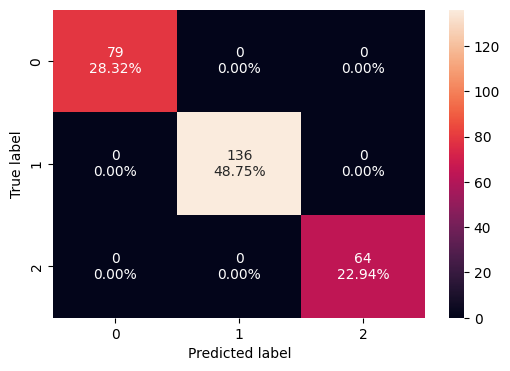

In [92]:
confusion_matrix_sklearn(rf_word2vec, X_train_word2vec, y_train_word2vec)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

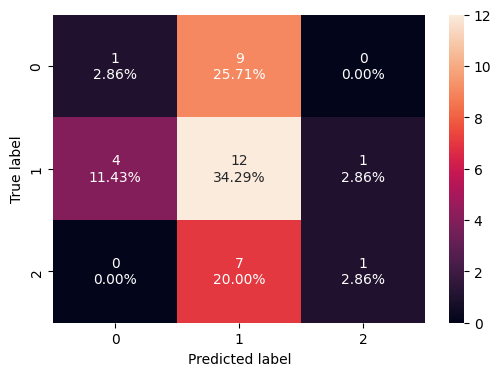

In [93]:
confusion_matrix_sklearn(rf_word2vec, X_valid_word2vec, y_valid_word2vec)

Observations:
- Around 40% of the predicted values match with the actual values.

In [94]:
# Predicting on train data
y_pred_train_word2vec = rf_word2vec.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_word2vec = rf_word2vec.predict(X_valid_word2vec)

**Classification Report**

In [95]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [96]:
default_word2vec_report = classification_report(y_valid_word2vec, y_pred_valid_word2vec)
print(default_word2vec_report)

              precision    recall  f1-score   support

          -1       0.20      0.10      0.13        10
           0       0.43      0.71      0.53        17
           1       0.50      0.12      0.20         8

    accuracy                           0.40        35
   macro avg       0.38      0.31      0.29        35
weighted avg       0.38      0.40      0.34        35



Observations:
  - We got a weighted recall score of 40% which indicates that the model was overfitting.
     - Negative sentiment recall score is 10%
     - Neutral sentiment recall score is 71%
     - Positive sentiment recall score is 12%

#### Random Forest Model (default with GloVe)

In [97]:
# Building the model
rf_glove = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_glove.fit(X_train_glove, y_train_glove)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

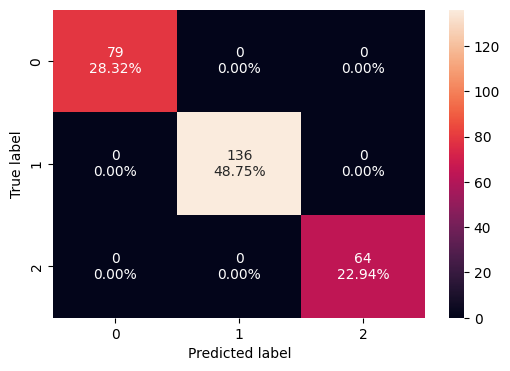

In [98]:
confusion_matrix_sklearn(rf_glove, X_train_glove, y_train_glove)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

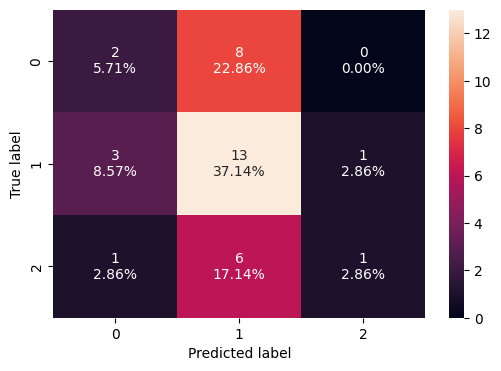

In [99]:
confusion_matrix_sklearn(rf_glove, X_valid_glove, y_valid_glove)

Observations:
 - Around 46% of the predicted values match the true values.

In [100]:
# Predicting on train data
y_pred_train_glove = rf_glove.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove = rf_glove.predict(X_valid_glove)

**Classification Report**

In [101]:
print(classification_report(y_train_glove, y_pred_train_glove))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [102]:
default_glove_report = classification_report(y_valid_glove, y_pred_valid_glove)
print(default_glove_report)

              precision    recall  f1-score   support

          -1       0.33      0.20      0.25        10
           0       0.48      0.76      0.59        17
           1       0.50      0.12      0.20         8

    accuracy                           0.46        35
   macro avg       0.44      0.36      0.35        35
weighted avg       0.44      0.46      0.40        35



Observations:
  - We got a weighted recall score of 46% which indicates that the model was overfitting.
     - Negative sentiment recall score is 20%
     - Neutral sentiment recall score is 76%
     - Positive sentiment recall score is 12%

#### Random Forest Model (default with Sentence Transformer)

In [103]:
rf_sent_transformer = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_sent_transformer.fit(X_train_sent_transformer, y_train_sent_transformer)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

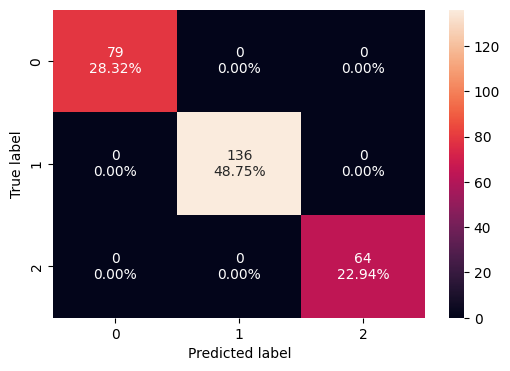

In [104]:
confusion_matrix_sklearn(rf_sent_transformer, X_train_sent_transformer, y_train_sent_transformer)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

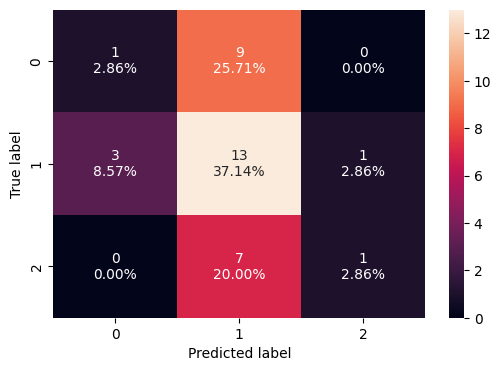

In [105]:
confusion_matrix_sklearn(rf_sent_transformer, X_valid_sent_transformer, y_valid_sent_transformer)

Observations:
 - For Validation dataset, around 43% of the predicted values match the true values.

In [106]:
# Predicting on train data
y_pred_train_sent_transformer = rf_sent_transformer.predict(X_train_sent_transformer)

# Predicting on validation data
y_pred_valid_sent_transformer = rf_sent_transformer.predict(X_valid_sent_transformer)

**Classification Report**

In [107]:
print(classification_report(y_train_sent_transformer, y_pred_train_sent_transformer))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [108]:
#included zero_division=1 to address the warning related to precision values
default_sent_report = classification_report(y_valid_sent_transformer, y_pred_valid_sent_transformer, zero_division=1)
print(default_sent_report)

              precision    recall  f1-score   support

          -1       0.25      0.10      0.14        10
           0       0.45      0.76      0.57        17
           1       0.50      0.12      0.20         8

    accuracy                           0.43        35
   macro avg       0.40      0.33      0.30        35
weighted avg       0.40      0.43      0.36        35



Observations:
  - We got a weighted recall score of 43% which indicates that the model was overfitting.
     - Negative sentiment recall score is 10%
     - Neutral sentiment recall score is 76%
     - Positive sentiment recall score is 12%

**We'll try to address the class imbalance problem now with Class weights.**

#### Random Forest (with class_weights and Word2Vec)

In [109]:
rf_word2vec_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_word2vec_balanced.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Confusion Matrix**

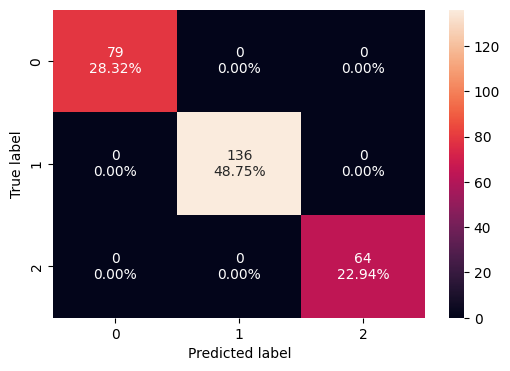

In [110]:
confusion_matrix_sklearn(rf_word2vec_balanced, X_train_word2vec, y_train_word2vec)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

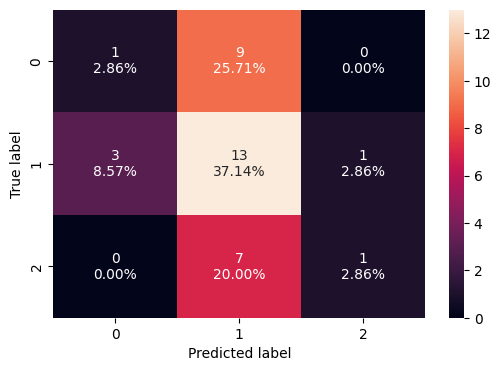

In [111]:
confusion_matrix_sklearn(rf_word2vec_balanced, X_valid_word2vec, y_valid_word2vec)

Observations:
 - For Validation dataset, around 43% of the predicted values match the true values.

In [112]:
# Predicting on train data
y_pred_train_word2vec_balanced = rf_word2vec_balanced.predict(X_train_word2vec)

# Predicting on test data
y_pred_valid_word2vec_balanced = rf_word2vec_balanced.predict(X_valid_word2vec)

**Classification report**

In [113]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec_balanced))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [114]:
weighted_word2vec_report = classification_report(y_valid_word2vec, y_pred_valid_word2vec_balanced)
print(weighted_word2vec_report)

              precision    recall  f1-score   support

          -1       0.25      0.10      0.14        10
           0       0.45      0.76      0.57        17
           1       0.50      0.12      0.20         8

    accuracy                           0.43        35
   macro avg       0.40      0.33      0.30        35
weighted avg       0.40      0.43      0.36        35



Observations:
  - We got a weighted recall score of 43% which indicates that the model was overfitting.
     - Negative sentiment recall score is 10%
     - Neutral sentiment recall score is 76%
     - Positive sentiment recall score is 12%

#### Random Forest (with class_weights and GloVe)

In [115]:
rf_glove_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_glove_balanced.fit(X_train_glove, y_train_glove)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Confusion Matrix**

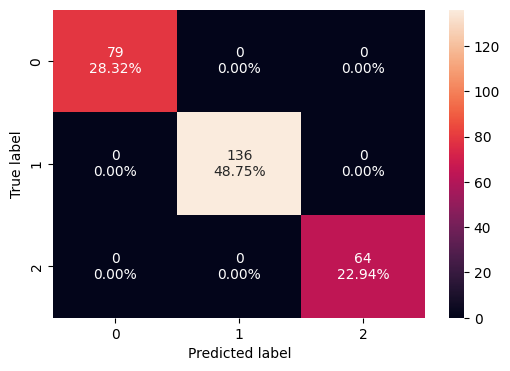

In [116]:
confusion_matrix_sklearn(rf_glove_balanced, X_train_glove, y_train_glove)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

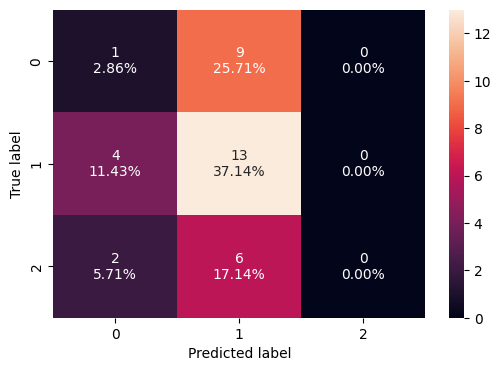

In [117]:
confusion_matrix_sklearn(rf_glove_balanced, X_valid_glove, y_valid_glove)

Observations,
  - For validation dataset, we see that around 40% of the predicted values match with the true values.

In [118]:
# Predicting on train data
y_pred_train_glove_balanced = rf_glove_balanced.predict(X_train_glove)

# Predicting on test data
y_pred_valid_glove_balanced = rf_glove_balanced.predict(X_valid_glove)

**Classification report**

In [119]:
print(classification_report(y_train_glove, y_pred_train_glove_balanced))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [120]:
weighted_glove_report = classification_report(y_valid_glove, y_pred_valid_glove_balanced, zero_division=1)
print(weighted_glove_report)

              precision    recall  f1-score   support

          -1       0.14      0.10      0.12        10
           0       0.46      0.76      0.58        17
           1       1.00      0.00      0.00         8

    accuracy                           0.40        35
   macro avg       0.54      0.29      0.23        35
weighted avg       0.49      0.40      0.31        35



Observations:
  - We got a weighted recall score of 40% which indicates that the model was overfitting.
     - Negative sentiment recall score is 10%
     - Neutral sentiment recall score is 76%
     - Positive sentiment recall score is 0%

#### Random Forest (with class_weights and Sentence Transformer)

In [121]:
rf_sent_transformer_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_sent_transformer_balanced.fit(X_train_sent_transformer, y_train_sent_transformer)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Confusion Matrix**

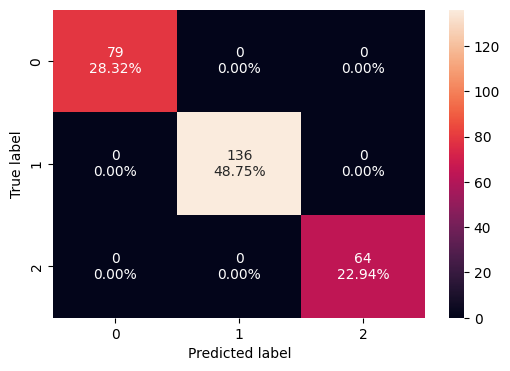

In [122]:
confusion_matrix_sklearn(rf_sent_transformer_balanced, X_train_sent_transformer, y_train_sent_transformer)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

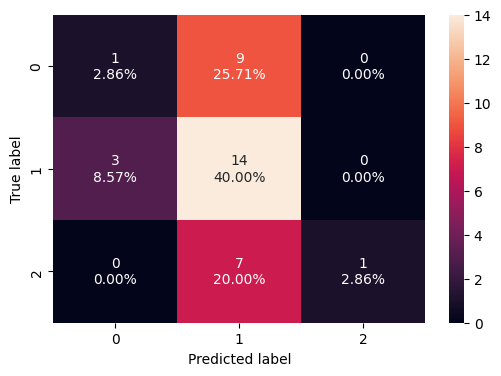

In [123]:
confusion_matrix_sklearn(rf_sent_transformer_balanced, X_valid_sent_transformer, y_valid_sent_transformer)

Observations:
 - For validation dataset, we see around 46% of the predicted values match the actual values.

In [124]:
#predicting on train data
y_pred_train_sent_transformer_balanced = rf_sent_transformer_balanced.predict(X_train_sent_transformer)

#predicting on test data
y_pred_valid_sent_transformer_balanced = rf_sent_transformer_balanced.predict(X_valid_sent_transformer)

**Classification Report**

In [125]:
print(classification_report(y_train_sent_transformer, y_pred_train_sent_transformer_balanced))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [126]:
weighted_sent_report = classification_report(y_valid_sent_transformer, y_pred_valid_sent_transformer_balanced, zero_division=1)
print(weighted_sent_report)

              precision    recall  f1-score   support

          -1       0.25      0.10      0.14        10
           0       0.47      0.82      0.60        17
           1       1.00      0.12      0.22         8

    accuracy                           0.46        35
   macro avg       0.57      0.35      0.32        35
weighted avg       0.53      0.46      0.38        35



Observations:
  - We got a weighted recall score of 46% which indicates that the model was overfitting.
     - Negative sentiment recall score is 10%
     - Neutral sentiment recall score is 82%
     - Positive sentiment recall score is 12%

#### Random Forest (with hyperparameter tuning and Word2Vec)

In [127]:
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_word2vec, y_train_word2vec)

In [128]:
# Creating a new model with the best combination of parameters
rf_word2vec_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_word2vec_tuned.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       min_samples_split=6, n_estimators=30, random_state=42)

**Confusion Matrix**

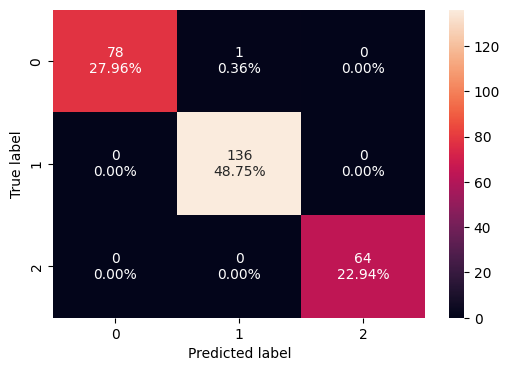

In [129]:
confusion_matrix_sklearn(rf_word2vec_tuned, X_train_word2vec, y_train_word2vec)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

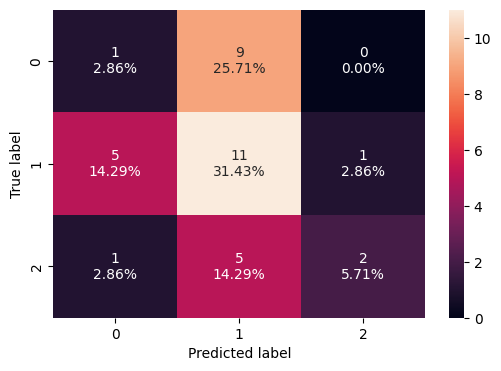

In [130]:
confusion_matrix_sklearn(rf_word2vec_tuned, X_valid_word2vec, y_valid_word2vec)

Observations:
 - For validation dataset, around 40% of the predicted values match the actual values.

In [131]:
# Predicting on train data
y_pred_train_word2vec_tuned = rf_word2vec_tuned.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_word2vec_tuned = rf_word2vec_tuned.predict(X_valid_word2vec)

**Classification Report**

In [132]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec_tuned))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99        79
           0       0.99      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 99% which still indicates that the model is overfitting.

In [133]:
tuned_word2vec_report = classification_report(y_valid_word2vec, y_pred_valid_word2vec_tuned)
print(tuned_word2vec_report)

              precision    recall  f1-score   support

          -1       0.14      0.10      0.12        10
           0       0.44      0.65      0.52        17
           1       0.67      0.25      0.36         8

    accuracy                           0.40        35
   macro avg       0.42      0.33      0.34        35
weighted avg       0.41      0.40      0.37        35



Observations:
  - We got a weighted recall score of 40% which indicates that the model was overfitting.
     - Negative sentiment recall score is 10%
     - Neutral sentiment recall score is 65%
     - Positive sentiment recall score is 25%

#### Random Forest (with hyperparametertuning and GloVe)



In [134]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_glove)

In [135]:
# Creating a new model with the best combination of parameters
rf_glove_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_glove_tuned.fit(X_train_glove, y_train_glove)

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       min_samples_split=5, random_state=42)

**Confusion Matrix**

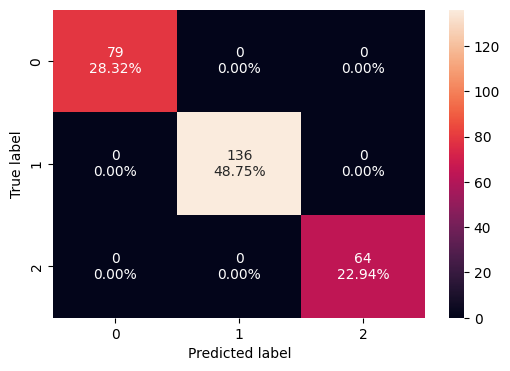

In [136]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_train_glove, y_train_glove)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

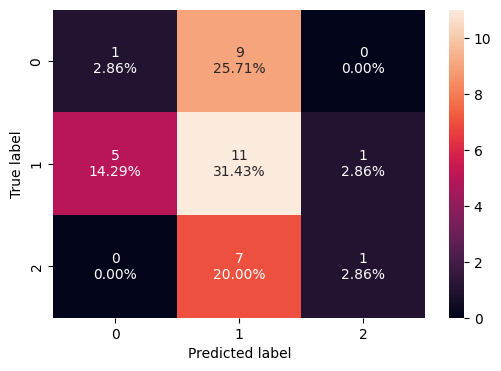

In [137]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_valid_glove, y_valid_glove)

Observations:
 - For validation dataset, we see that around 37% of the predicted values match the actual values.

In [138]:
# Predicting on train data
y_pred_train_glove_tuned = rf_glove_tuned.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove_tuned = rf_glove_tuned.predict(X_valid_glove)

**Classification Report**

In [139]:
print(classification_report(y_train_glove, y_pred_train_glove_tuned))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [140]:
tuned_glove_report = classification_report(y_valid_glove, y_pred_valid_glove_tuned)
print(tuned_glove_report)

              precision    recall  f1-score   support

          -1       0.17      0.10      0.12        10
           0       0.41      0.65      0.50        17
           1       0.50      0.12      0.20         8

    accuracy                           0.37        35
   macro avg       0.36      0.29      0.27        35
weighted avg       0.36      0.37      0.32        35



Observations:
  - We got a weighted recall score of 37% which indicates that the model was overfitting.
     - Negative sentiment recall score is 10%
     - Neutral sentiment recall score is 65%
     - Positive sentiment recall score is 12%

#### Random Forest (with hyperparameter tuning and Sentence transformer)

In [141]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_sent_transformer, y_train_sent_transformer)

In [142]:
# Creating a new model with the best combination of parameters
rf_sent_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_sent_tuned.fit(X_train_sent_transformer, y_train_sent_transformer)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=5, n_estimators=80, random_state=42)

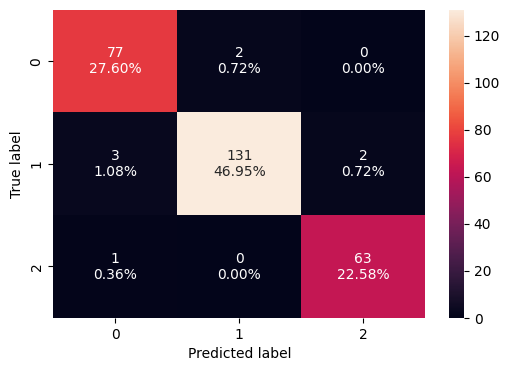

In [143]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_sent_tuned, X_train_sent_transformer, y_train_sent_transformer)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

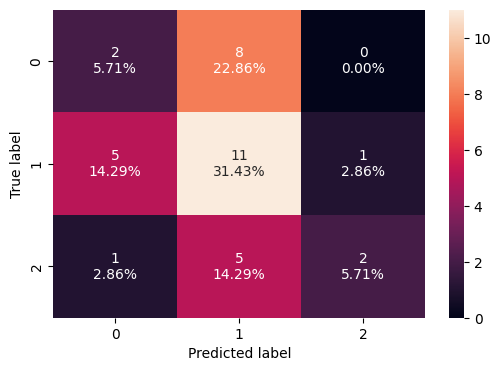

In [144]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_sent_tuned, X_valid_sent_transformer, y_valid_sent_transformer)

Observations:
 - For validation dataset, we see that around 43% of the predicted values match the actual values.

In [145]:
# Predicting on train data
y_pred_train_sent_tuned = rf_sent_tuned.predict(X_train_sent_transformer)

# Predicting on validation data
y_pred_valid_sent_tuned = rf_sent_tuned.predict(X_valid_sent_transformer)

**Classification Report**

In [146]:
print(classification_report(y_train_sent_transformer, y_pred_train_sent_tuned))

              precision    recall  f1-score   support

          -1       0.95      0.97      0.96        79
           0       0.98      0.96      0.97       136
           1       0.97      0.98      0.98        64

    accuracy                           0.97       279
   macro avg       0.97      0.97      0.97       279
weighted avg       0.97      0.97      0.97       279



Observations:
 - For training data, We have a Recall score of 97%.

In [147]:
tuned_sent_report = classification_report(y_valid_sent_transformer, y_pred_valid_sent_tuned)
print(tuned_sent_report)

              precision    recall  f1-score   support

          -1       0.25      0.20      0.22        10
           0       0.46      0.65      0.54        17
           1       0.67      0.25      0.36         8

    accuracy                           0.43        35
   macro avg       0.46      0.37      0.37        35
weighted avg       0.45      0.43      0.41        35



Observations:
  - We got a weighted recall score of 43% which indicates that the model was overfitting.
     - Negative sentiment recall score is 20%
     - Neutral sentiment recall score is 65%
     - Positive sentiment recall score is 25%

#### XGBoost (default and Word2Vec)

In [148]:
import pandas as pd
from xgboost import XGBClassifier

#XGBoost doesnt take negative values/classes in y. So map the classes to positive number
# Assuming y_train_word2vec is a pandas Series
y_train_xgb_word2vec = y_train_word2vec.map({-1: 0, 0: 1, 1: 2})  # Change -1 to 0, 0 to 1, and 1 to 2

#Fitting the model
xgb_word2vec = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_word2vec.fit(X_train_word2vec, y_train_xgb_word2vec)

y_valid_xgb_word2vec = y_valid_word2vec.map({-1: 0, 0: 1, 1: 2})  # Change -1 to 0, 0 to 1, and 1 to 2

**Confusion Matrix**

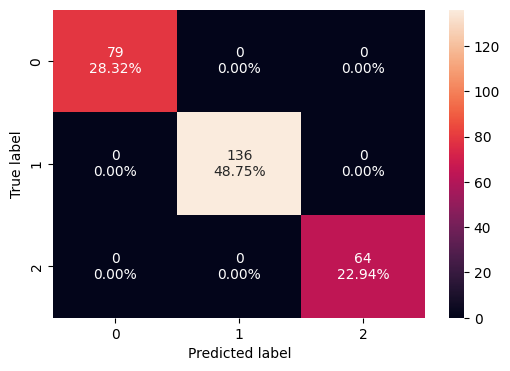

In [149]:
confusion_matrix_sklearn(xgb_word2vec, X_train_word2vec, y_train_xgb_word2vec)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

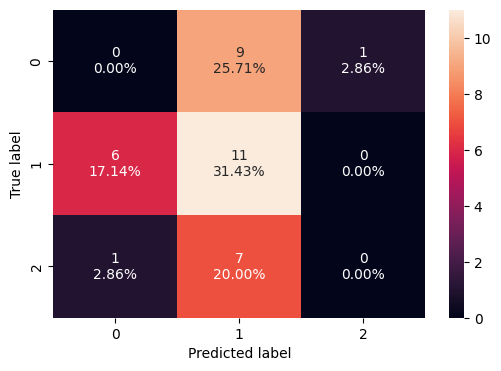

In [150]:
confusion_matrix_sklearn(xgb_word2vec, X_valid_word2vec, y_valid_xgb_word2vec)

Observations:
 - For Validation dataset, we see that around 34% of the predicted values match the actual values.

In [151]:
# Predicting on train data
y_pred_train_xgbword2vec = xgb_word2vec.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_xgbword2vec = xgb_word2vec.predict(X_valid_word2vec)

**Classification Report**

In [152]:
print(classification_report(y_train_xgb_word2vec, y_pred_train_xgbword2vec))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [153]:
default_xgb_word2vec_report = classification_report(y_valid_xgb_word2vec, y_pred_valid_xgbword2vec)
print(default_xgb_word2vec_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.41      0.65      0.50        17
           2       0.00      0.00      0.00         8

    accuracy                           0.31        35
   macro avg       0.14      0.22      0.17        35
weighted avg       0.20      0.31      0.24        35



Observations:
  - We got a weighted recall score of 34% which indicates that the model was overfitting.
     - Negative sentiment recall score is 0%
     - Neutral sentiment recall score is 65%
     - Positive sentiment recall score is 0%

#### XGBoost Model (default with GloVe)

In [154]:
#XGBoost doesnt take negative values/classes in y. So map the classes to positive number
y_train_xgb_glove = y_train_glove.map({-1: 0, 0: 1, 1: 2})  # Change -1 to 0, 0 to 1, and 1 to 2
y_valid_xgb_glove = y_valid_glove.map({-1: 0, 0: 1, 1: 2})  # Change -1 to 0, 0 to 1, and 1 to 2

In [155]:
# Building the model
xgb_glove = XGBClassifier(random_state = 42)

# Fitting on train data
xgb_glove.fit(X_train_glove, y_train_xgb_glove)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

**Confusion Matrix**

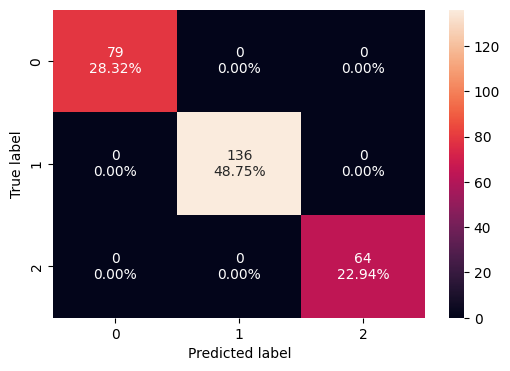

In [156]:
confusion_matrix_sklearn(xgb_glove, X_train_glove, y_train_xgb_glove)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

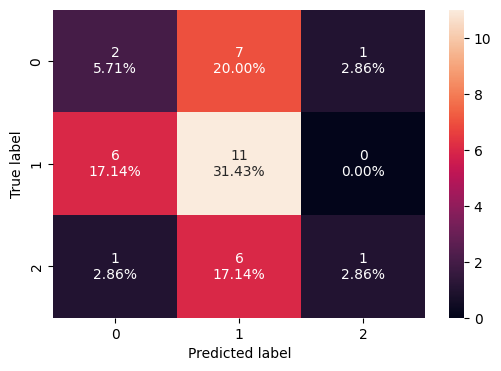

In [157]:
confusion_matrix_sklearn(xgb_glove, X_valid_glove, y_valid_xgb_glove)

Observations:
  - For Validation dataset, we see that around 40% of the predicted values match the actual values.

In [158]:
# Predicting on train data
y_pred_train_xgb_glove = xgb_glove.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_xgb_glove = xgb_glove.predict(X_valid_glove)

**Classification Report**

In [159]:
print(classification_report(y_train_xgb_glove, y_pred_train_xgb_glove))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [160]:
default_xgb_glove_report = classification_report(y_valid_xgb_glove, y_pred_valid_xgb_glove)
print(default_xgb_glove_report)

              precision    recall  f1-score   support

           0       0.22      0.20      0.21        10
           1       0.46      0.65      0.54        17
           2       0.50      0.12      0.20         8

    accuracy                           0.40        35
   macro avg       0.39      0.32      0.32        35
weighted avg       0.40      0.40      0.37        35



Observations:
  - We got a weighted recall score of 40% which indicates that the model was overfitting.
     - Negative sentiment recall score is 20%
     - Neutral sentiment recall score is 65%
     - Positive sentiment recall score is 12%

#### XGBoost Model (default with Sentence Transformer)

In [161]:
#XGBoost doesnt take negative values/classes in y. So map the classes to positive number
y_train_xgb_sent_transformer = y_train_sent_transformer.map({-1: 0, 0: 1, 1: 2})  # Change -1 to 0, 0 to 1, and 1 to 2
y_valid_xgb_sent_transformer = y_valid_sent_transformer.map({-1: 0, 0: 1, 1: 2})  # Change -1 to 0, 0 to 1, and 1 to 2

In [162]:
xgb_sent_transformer = XGBClassifier(random_state = 42)

# Fitting on train data
xgb_sent_transformer.fit(X_train_sent_transformer, y_train_xgb_sent_transformer)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

**Confusion Matrix**

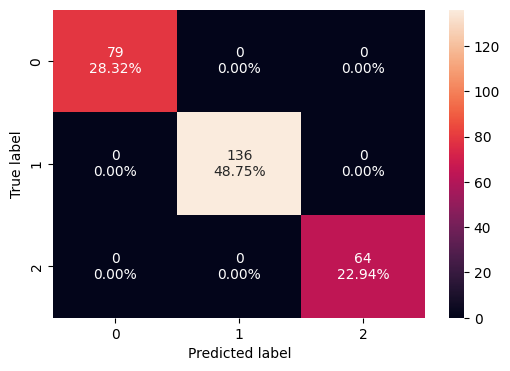

In [163]:
confusion_matrix_sklearn(xgb_sent_transformer, X_train_sent_transformer, y_train_xgb_sent_transformer)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

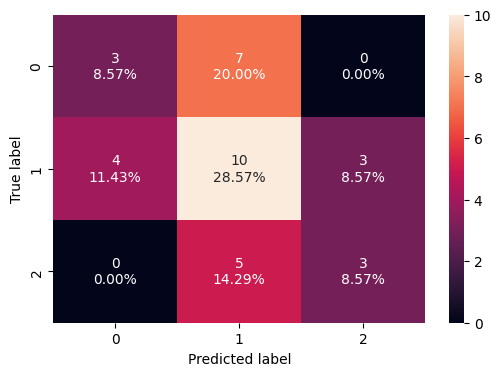

In [164]:
confusion_matrix_sklearn(xgb_sent_transformer, X_valid_sent_transformer, y_valid_xgb_sent_transformer)

Observations:
  - For validation dataset, we see that around 46% of the predicted values match the actual values.

In [165]:
# Predicting on train data
y_pred_train_xgb_sent_transformer = xgb_sent_transformer.predict(X_train_sent_transformer)

# Predicting on validation data
y_pred_valid_xgb_sent_transformer = xgb_sent_transformer.predict(X_valid_sent_transformer)

**Classification Report**

In [166]:
print(classification_report(y_train_xgb_sent_transformer, y_pred_train_xgb_sent_transformer))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [167]:
#included zero_division=1 to address the warning related to precision values
default_xgb_sent_report = classification_report(y_valid_xgb_sent_transformer, y_pred_valid_xgb_sent_transformer, zero_division=1)
print(default_xgb_sent_report)

              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.45      0.59      0.51        17
           2       0.50      0.38      0.43         8

    accuracy                           0.46        35
   macro avg       0.46      0.42      0.43        35
weighted avg       0.46      0.46      0.45        35



Observations:
  - We got a weighted recall score of 46% which indicates that the model was overfitting.
     - Negative sentiment recall score is 30%
     - Neutral sentiment recall score is 59%
     - Positive sentiment recall score is 38%

#### XGBoost (with hyperparameter tuning and Word2Vec)

In [168]:
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier
xgb_tuned = XGBClassifier(random_state=42, eval_metric='mlogloss')

# defining the hyperparameter grid for tuning
parameters = {
    "n_estimators": [10,30,50],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_word2vec, y_train_xgb_word2vec)

In [169]:
# Creating a new model with the best combination of parameters
xgb_word2vec_tuned = grid_obj.best_estimator_

# Fit the new model to the data
xgb_word2vec_tuned.fit(X_train_word2vec, y_train_xgb_word2vec)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

**Confusion Matrix**

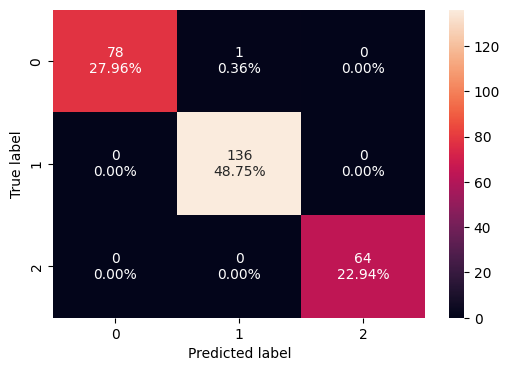

In [170]:
confusion_matrix_sklearn(xgb_word2vec_tuned, X_train_word2vec, y_train_xgb_word2vec)

Observations:
 - Around 4.7% predicted values dont match with true values.

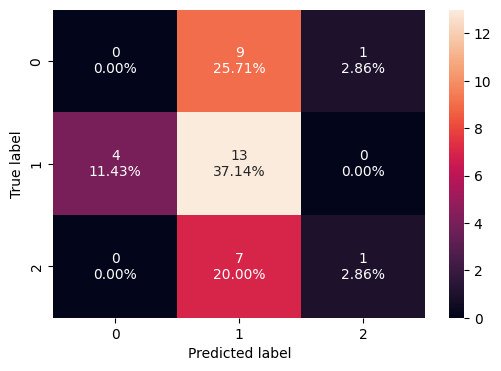

In [171]:
confusion_matrix_sklearn(xgb_word2vec_tuned, X_valid_word2vec, y_valid_xgb_word2vec)

Observations:
  - For validation dataset, we see that around 37% of the predicted values match the actual values.

In [172]:
# Predicting on train data
y_pred_train_xgb_word2vec_tuned = xgb_word2vec_tuned.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_xgb_word2vec_tuned = xgb_word2vec_tuned.predict(X_valid_word2vec)

**Classification Report**

In [173]:
print(classification_report(y_train_xgb_word2vec, y_pred_train_xgb_word2vec_tuned))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       0.99      1.00      1.00       136
           2       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 95%.

In [174]:
xgb_tuned_word2vec_report = classification_report(y_valid_xgb_word2vec, y_pred_valid_xgb_word2vec_tuned)
print(xgb_tuned_word2vec_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.45      0.76      0.57        17
           2       0.50      0.12      0.20         8

    accuracy                           0.40        35
   macro avg       0.32      0.30      0.26        35
weighted avg       0.33      0.40      0.32        35



Observations:
  - We got a weighted recall score of 37% which indicates that the model was overfitting.
     - Negative sentiment recall score is 0%
     - Neutral sentiment recall score is 76%
     - Positive sentiment recall score is 0%

#### XGBoost (with hyperparametertuning and GloVe)



In [175]:
# Choose the type of classifier
xgb_tuned = XGBClassifier(random_state=42, eval_metric='mlogloss')

# defining the hyperparameter grid for tuning
parameters = {
    "n_estimators": [10,30,50],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}
# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_xgb_glove)

In [176]:
# Creating a new model with the best combination of parameters
xgb_glove_tuned = grid_obj.best_estimator_

# Fit the new model to the data
xgb_glove_tuned.fit(X_train_glove, y_train_xgb_glove)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

**Confusion Matrix**

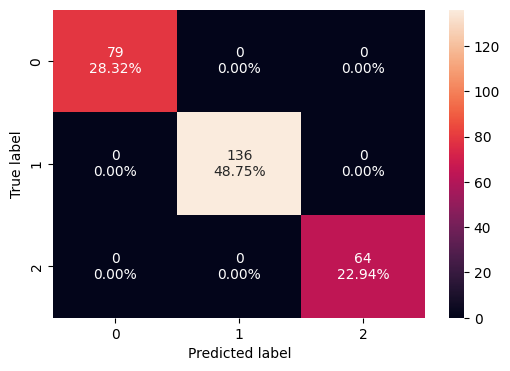

In [177]:
#Printing the confusion matrix
confusion_matrix_sklearn(xgb_glove_tuned, X_train_glove, y_train_xgb_glove)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

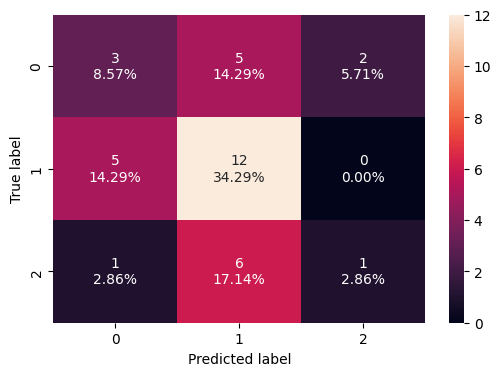

In [178]:
#Printing the confusion matrix
confusion_matrix_sklearn(xgb_glove_tuned, X_valid_glove, y_valid_xgb_glove)

Observations:
  - For validation dataset, we see that around 46% of the predicted values match the actual values.

In [179]:
# Predicting on train data
y_pred_train_xgb_glove_tuned = xgb_glove_tuned.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_xgb_glove_tuned = xgb_glove_tuned.predict(X_valid_glove)

**Classification Report**

In [180]:
print(classification_report(y_train_xgb_glove, y_pred_train_xgb_glove_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [181]:
xgb_tuned_glove_report = classification_report(y_valid_xgb_glove, y_pred_valid_xgb_glove_tuned)
print(xgb_tuned_glove_report)

              precision    recall  f1-score   support

           0       0.33      0.30      0.32        10
           1       0.52      0.71      0.60        17
           2       0.33      0.12      0.18         8

    accuracy                           0.46        35
   macro avg       0.40      0.38      0.37        35
weighted avg       0.42      0.46      0.42        35



Observations:
  - We got a weighted recall score of 46% which indicates that the model was overfitting.
     - Negative sentiment recall score is 30%
     - Neutral sentiment recall score is 71%
     - Positive sentiment recall score is 12%

#### XGBoost(with Hyperparameter Tuning and Sentence Transformer)

In [182]:
# Choose the type of classifier
xgb_tuned = XGBClassifier(random_state=42, eval_metric='mlogloss')

# defining the hyperparameter grid for tuning
parameters = {
    "n_estimators": [10,30,50],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}
# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_sent_transformer, y_train_xgb_sent_transformer)

In [183]:
# Creating a new model with the best combination of parameters
xgb_sent_tuned = grid_obj.best_estimator_

# Fit the new model to the data
xgb_sent_tuned.fit(X_train_sent_transformer, y_train_xgb_sent_transformer)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

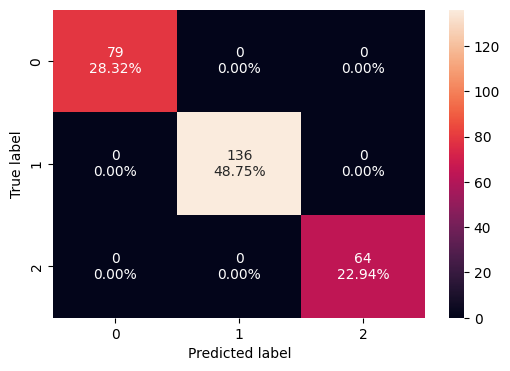

In [184]:
#Printing the confusion matrix
confusion_matrix_sklearn(xgb_sent_tuned, X_train_sent_transformer, y_train_xgb_sent_transformer)

Observations:
  - We see that all predicted values matches the true/actual values and it looks like that the data is overfitting.

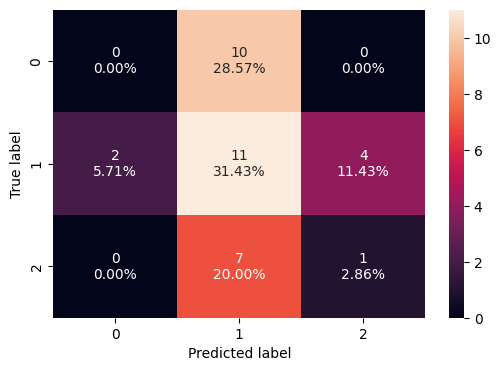

In [185]:
#Printing the confusion matrix
confusion_matrix_sklearn(xgb_sent_tuned, X_valid_sent_transformer, y_valid_xgb_sent_transformer)

Observations:
  - For validation dataset, we see that around 34% of the predicted values match the actual values.

In [186]:
# Predicting on train data
y_pred_train_xgb_sent_tuned = xgb_sent_tuned.predict(X_train_sent_transformer)

# Predicting on validation data
y_pred_valid_xgb_sent_tuned = xgb_sent_tuned.predict(X_valid_sent_transformer)

**Classification Report**

In [187]:
print(classification_report(y_train_xgb_sent_transformer, y_pred_train_xgb_sent_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



Observations:
 - For training data, We have a Recall score of 100% which indicates that the model is overfitting.

In [188]:
xgb_tuned_sent_report = classification_report(y_valid_xgb_sent_transformer, y_pred_valid_xgb_sent_tuned)
print(xgb_tuned_sent_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.39      0.65      0.49        17
           2       0.20      0.12      0.15         8

    accuracy                           0.34        35
   macro avg       0.20      0.26      0.21        35
weighted avg       0.24      0.34      0.27        35



Observations:
  - We got a weighted recall score of 34% which indicates that the model was overfitting.
     - Negative sentiment recall score is 0%
     - Neutral sentiment recall score is 65%
     - Positive sentiment recall score is 12%

#### Models Performance Summary

In [189]:
# Summarize all the reports
def summarize_reports(reports, model_type):
    """Summarizes model reports in a structured format.

    Args:
        reports (dict): A dictionary of reports where keys are report names
                       and values are the actual report objects.
        model_type (str): The type of model (e.g., "Random Forest", "XGBoost").

    Returns:
        None (prints the summary to the console)
    """
    print(f"-----------------{model_type.upper()} MODELS---------------------- ")
    for report_name, report in reports.items():
        print(f"\n{report_name.replace('_', ' ').title()} Report:")
        print(report)
    print("-" * 50)

# Define dictionaries to hold your reports
random_forest_reports = {
    "default_word2vec": default_word2vec_report,
    "weighted_word2vec": weighted_word2vec_report,
    "tuned_word2vec": tuned_word2vec_report,
    "default_glove": default_glove_report,
    "weighted_glove": weighted_glove_report,
    "tuned_glove": tuned_glove_report,
    "default_sentence_transformer": default_sent_report,
    "weighted_sentence_transformer": weighted_sent_report,
    "tuned_sentence_transformer": tuned_sent_report,
}

xgboost_reports = {
    "default_word2vec": default_xgb_word2vec_report,
    "tuned_word2vec": xgb_tuned_word2vec_report,
    "default_glove": default_xgb_glove_report,
    "tuned_glove": xgb_tuned_glove_report,
    "default_sentence_transformer": default_xgb_sent_report,
    "tuned_sentence_transformer": xgb_tuned_sent_report,
}

# Print the summarized reports
print("Metrics summary of all the models")
print("-" * 50)

summarize_reports(random_forest_reports, "Random Forest")
summarize_reports(xgboost_reports, "XGBoost")

Metrics summary of all the models
--------------------------------------------------
-----------------RANDOM FOREST MODELS---------------------- 

Default Word2Vec Report:
              precision    recall  f1-score   support

          -1       0.20      0.10      0.13        10
           0       0.43      0.71      0.53        17
           1       0.50      0.12      0.20         8

    accuracy                           0.40        35
   macro avg       0.38      0.31      0.29        35
weighted avg       0.38      0.40      0.34        35


Weighted Word2Vec Report:
              precision    recall  f1-score   support

          -1       0.25      0.10      0.14        10
           0       0.45      0.76      0.57        17
           1       0.50      0.12      0.20         8

    accuracy                           0.43        35
   macro avg       0.40      0.33      0.30        35
weighted avg       0.40      0.43      0.36        35


Tuned Word2Vec Report:
              p

**Model Performance Summary :**
  - We have built 15 models( 9 Random Forest models and 6 XGBoost Model) using Word2vec, Glove and Sentence Transformer embedding. Our metric of interest is Recall.
  - We observe that there are top 4 models with the highest recall score of 46%. Below are the models
     - Random Forest - Default Glove Model
     - Random Forest - Weighted Sentence Transformer Model
     - XGBoost - Tuned Glove Model
     - XGBoost - Default Sentence Transformer Model

   -  Lets dive further to look at other factors to choose the right model
      - Class-wise Recall :
          - Random Forest - Default Glove Model
              - Negative sentiment recall score is 20%
              - Neutral sentiment recall score is 76%
              - Positive sentiment recall score is 12%
          - Random Forest - Weighted Sentence Transformer Model
              - Negative sentiment recall score is 10%
              - Neutral sentiment recall score is 82%
              - Positive sentiment recall score is 12%
          - XGBoost - Tuned Glove Model
              - Negative sentiment recall score is 30%
              - Neutral sentiment recall score is 71%
              - Positive sentiment recall score is 12%
          - XGBoost - Default Sentence Transformer Model
              - Negative sentiment recall score is 30%
              - Neutral sentiment recall score is 59%
              - Positive sentiment recall score is 38%
                       
          By Observation, we see XGBoost - Default Sentence Transformer Model class Wise recall score for Negative and positive sentiments are better than other models.

      - Computational Efficiency :
          - Default Models - need the least computational resources
          - Weighted Models - Second least resources after the default Models
          - Hyper parameter tuning Models- needs more computational resources
                       
          - For Sentence Transformers, we do not have to pre-process or clean the data, we can feed the input as is which saves  computational resource
          
          By Observation, we see that XGBoost - Default Sentence Transformer Model  requires less computational resource

      - Other Metrics like F1-Score :
          - The Second critical métricas is F1-Score which keeps a balance between Precision and Recall.
          - Random Forest - Default Glove Model
              - F1- Score is 40%
          - Random Forest - Weighted Sentence Transformer Model
              - F1-Score is 38%
          - XGBoost - Tuned Glove Model
              - F1-Score is 42%
          - XGBoost - Default Sentence Transformer Model
              - F1-Score is 45%

          By observation, we see that XGBoost - Default Sentence Transformer Model has the highest F1-Score of 45%

**Final Model: Based on all the criteria above, XGBoost - Default Sentence Transformer Model is the best model.**

#### Final Model Performance on Test Data

In [190]:
# Predicting on validation data
y_pred_test_xgb_sent_transformer = xgb_sent_transformer.predict(X_test_sent_transformer)

**Confusion Matrix**

In [192]:
#XGBoost doesnt take negative values/classes in y. So map the classes to positive number
y_test_xgb_sent_transformer = y_test_sent_transformer.map({-1: 0, 0: 1, 1: 2})  # Change -1 to 0, 0 to 1, and 1 to 2

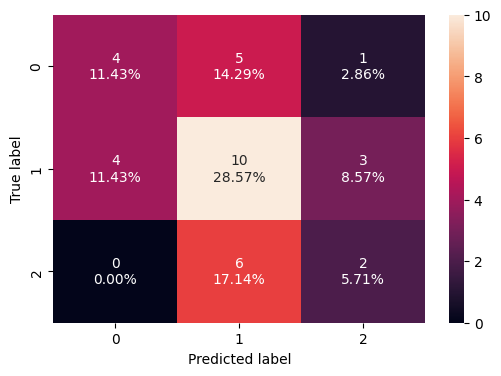

In [193]:
confusion_matrix_sklearn(xgb_sent_transformer, X_test_sent_transformer, y_test_xgb_sent_transformer)

**Classification Report**

In [194]:
#included zero_division=1 to address the warning related to precision values
final_model_report = classification_report(y_test_xgb_sent_transformer, y_pred_test_xgb_sent_transformer, zero_division=1)
print(final_model_report)

              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.48      0.59      0.53        17
           2       0.33      0.25      0.29         8

    accuracy                           0.46        35
   macro avg       0.44      0.41      0.42        35
weighted avg       0.45      0.46      0.45        35



**Final Model Summary : (XGBoost - Default Sentence Transformer)**

- Weighted Recall score on test data - 46%
- Class-wise Recall Scores
    - Negative Sentiment - 40%
    - Neutral Sentiment - 59%
    - Positive Sentiment - 25%
- F1-Score
    - F1-Score is 45%

**Conclusion :** Model has generalized well and has given the similar performance as validation dataset.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [1]:
!pip install git+https://github.com/abetlen/llama-cpp-python.git

  Cloning https://github.com/abetlen/llama-cpp-python.git to /tmp/pip-req-build-upp4trzd
  Running command git clone --filter=blob:none --quiet https://github.com/abetlen/llama-cpp-python.git /tmp/pip-req-build-upp4trzd
  Resolved https://github.com/abetlen/llama-cpp-python.git to commit b1d23df0bbd327b774083b5cf88e67ca0dd52b92
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00
  Created wheel for llama_cpp_python: filename=llama_cpp_python-0.3.9-cp311-cp311-linux_x86_64.whl size=4066894 sha256=144295e26a9a886092819ad3f1f388551fbaa2078de3ae0694b3bbee656212eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-zgyheaus/wheels/01/08/fb/81c44fda474774fbb40f7b407f3d53c6554c77fc88cd8774ac
Successfully built llama_cpp_python


In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

In [2]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

#### Loading the data

In [3]:
# mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# loading the dataset
df_summarization = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/Project/stock_news.csv')

In [5]:
data_summarization = df_summarization.copy()

#### Loading the model

In [26]:
import torch
from llama_cpp import Llama

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [27]:
print(device)

cuda


In [6]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [7]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [33]:
llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
    n_ctx=5500,  # Context window
)



llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [9]:
data_summarization["Date"] = pd.to_datetime(data_summarization['Date'])  # Convert the 'Date' column to datetime format.

In [10]:
# Group the data by week using the 'Date' column.
weekly_grouped = data_summarization.groupby(pd.Grouper(key='Date', freq='W'))

In [11]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [12]:
weekly_grouped

Date                                               News
0  2019-01-06   The tech sector experienced a significant dec...
1  2019-01-13   Sprint and Samsung plan to release 5G smartph...
2  2019-01-20   The U.S. stock market declined on Monday as c...
3  2019-01-27   The Swiss National Bank (SNB) governor, Andre...
4  2019-02-03   Caterpillar Inc reported lower-than-expected ...
5  2019-02-10   The Dow Jones Industrial Average, S&P 500, an...
6  2019-02-17   This week, the European Union's second highes...
7  2019-02-24   This news article discusses progress towards ...
8  2019-03-03   The Dow Jones Industrial Average and other ma...
9  2019-03-10   Spotify, the world's largest paid music strea...
10 2019-03-17   The United States opposes France's digital se...
11 2019-03-24   Facebook's stock price dropped more than 3% o...
12 2019-03-31   This news article reports that the S&P 500 In...
13 2019-04-07   Apple and other consumer brands, including LV...
14 2019-04-14   In March, mobile phone shipments to China dro...
15 2019-04-21   The chairman of Taiwan's Foxconn, Terry Gou, ...
16 2019-04-28   Taiwan's export orders continued to decline f...
17 2019-05-05   Spotify reported better-than-expected Q1 reve...

In [13]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [14]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

In [17]:
import nltk

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

token_counts = [len(word_tokenize(text)) for text in data_1['News']]
max_tokens = max(token_counts)
print(max_tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...


2902


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


##### Defining the response function

In [45]:
Instruction_1 = """
Role: You are an expert financial analyst specializing in market sentiment analysis and news summarization. Your primary role is to analyze weekly news articles related to a specific company and determine the top three positive and negative events that are most likely to affect its stock price.

Task: Analyze the provided news articles for the past week and identify the top three positive and negative events. These events should be the most significant occurrences reported in the news that could potentially influence the company's stock price. Summarize these events concisely and objectively.

Instructions:

1. Carefully read each news article provided for the specified week.
2. Extract key events or topics discussed in the articles.
3. Categorize the events as positive or negative based on their potential impact on the company's stock price. For example, a new product launch would generally be considered a positive event, while a product recall would be considered a negative event.
4. Rank the positive and negative events based on their significance and potential impact.
5. Select the top three most impactful positive events and the top three most impactful negative events.
6. Summarize each selected event in a clear and concise manner, avoiding subjective opinions or interpretations. Focus on factual reporting and avoid speculation.
7.Present the summarized events in a JSON format with two keys: "Positive Events" and "Negative Events." Each key should contain a list of the three summarized events in order of impact.

Example JSON Output:
{
  "Positive Events": [
    "Company announced a strategic partnership with a major industry player, potentially expanding its market reach.",
    "Positive earnings report exceeding analysts' expectations, indicating strong financial performance.",
    "New product launch receiving positive reviews and generating significant customer interest."
  ],
  "Negative Events": [
    "Product recall due to safety concerns, impacting sales and brand reputation.",
    "Regulatory investigation initiated against the company, potentially leading to fines or penalties.",
    "Key executive unexpectedly resigned, raising concerns about leadership stability."
  ]
}
"""

In [46]:
#length of the instructions
len(Instruction_1)

2228

In [47]:
#Defining the response function
def response_mistral(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=5500, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0, #Complete the code to set the value for temperature.
      top_p=0.95, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [48]:
#prompt with one instance
#use iloc to get one week
#create dataframe to store the output
test_data = response_mistral(Instruction_1, data_1['News'][0])


Llama.generate: 342 prefix-match hit, remaining 3877 prompt tokens to eval
llama_perf_context_print:        load time =  536836.20 ms
llama_perf_context_print: prompt eval time =  892804.63 ms /  6949 tokens (  128.48 ms per token,     7.78 tokens per second)
llama_perf_context_print:        eval time =  167820.69 ms /   345 runs   (  486.44 ms per token,     2.06 tokens per second)
llama_perf_context_print:       total time =  657331.89 ms /  7294 tokens


In [36]:
print(test_data)

 {
          "Positive Events": [
            "Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.",
            "FDIC Chair, Jelena McWilliams, expressed no concern over market volatility affecting the U.S banking system.",
            "Oil prices rebounded on Thursday due to dollar weakness, signs of output cuts by Saudi Arabia, and weaker fuel oil margins leading Riyadh to lower February prices for heavier crude grades sold to Asia."
          ],
          "Negative Events": [
            "Apple cut its quarterly revenue forecast for the first time in over 15 years due to weak iPhone sales in China, representing around 20% of Apple's revenue.",
            "Apple's profit warning led to an estimated $3.8 billion paper loss for Berkshire Hathaway due to its $252 million stake in Apple.",
            "Delta Air Lines reported lower-than-expected fourth quarter unit revenue growth, citing weaker than ant

In [49]:
import pandas as pd
from IPython.display import display

# Assuming data_1 is your DataFrame and 'News' is the column containing news articles

# Set display options to show all text
pd.set_option("display.max_colwidth", None)  # Display full column width

In [50]:
# Display the entire text of the first news article without truncation
display(data_1['News'][0])

' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

##### Checking the model output on the weekly data

In [51]:
data_1['model_response'] = data_1['News'].progress_apply(lambda x: response_mistral(Instruction_1, x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 4218 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =  536836.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =  190980.76 ms /   387 runs   (  493.49 ms per token,     2.03 tokens per second)
llama_perf_context_print:       total time =  191271.81 ms /   388 tokens
 11%|█         | 2/18 [03:11<25:30, 95.65s/it]Llama.generate: 474 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =  536836.20 ms
llama_perf_context_print: prompt eval time =  277458.09 ms /  2234 tokens (  124.20 ms per token,     8.05 tokens per second)
llama_perf_context_print:        eval time =  193923.86 ms /   424 runs   (  457.37 ms per token,     2.19 tokens per second)
llama_perf_context_print:       total time =  471714.38 ms /  2658 token

##### Formatting the model output

Extract the JSON data

In [52]:
data_1['model_response_parsed'] = data_1['model_response'].apply(extract_json_data)

In [53]:
data_1['model_response_parsed']

0                                                                                                                                                                                                                                                                                                                                                                                                 {'Positive Events': ['Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.', 'FDIC Chair, Jelena McWilliams, expressed no concern over market volatility affecting the U.S banking system.', 'Oil prices rebounded on Thursday due to dollar weakness, signs of output cuts by Saudi Arabia, and weaker fuel oil margins leading Riyadh to lower February prices for heavier crude grades sold to Asia.'], 'Negative Events': ['Apple cut its quarterly revenue forecast for the first time in over 15 years due to weak iPhone sales in China, representing around 20% of Apple's revenue.', 'Apple's profit warning led to an estimated $3.8 billion paper loss for Berkshire Hathaway due to its $252 million stake in Apple.', 'Apple's Q1 revenue guidance cut, resulting from weaker demand in China, led to significant losses for Berkshire Hathaway and a $21.4 billion decrease in its market value.']}
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             {'Positive Events': ['Sprint and Samsung planning 5G smartphone release in nine U.S. cities, expanding market reach', 'AMS developing new 3D facial recognition features for smartphones, reducing dependence on Apple', 'Deutsche Bank upgrades Universal Music Group valuation, identifying potential suitors'], 'Negative Events': ['AMS lowers revenue growth forecast due to weak demand from smartphone makers and automotive industry', 'Chinese smartphone market experiences decline in shipments, impacting sales for companies', 'European Commission launches investigation into Nike's tax treatment in the Netherlands']}
2                                                                                                                                                                                                                                                                                                                                       {'Positive Events': ['Dialog Semiconductor reported resilient fourth quarter revenue despite a decrease in iPhone sales at main customer Apple, leading to a 4% increase in the company's shares.', 'Verizon announced an expansion of its partnership with Apple Music, making it a built-in inclusion for certain data plans, deepening their partnership.', 'Netflix announced a price increase for U.S. subscribers and strong online sales during the holiday season, leading to gains in the technology and communication services sectors.'], 'Negative Events': ['Chinese trade data showed unexpected drops in exports and imports, leading to a halt in Europe's stock market rally and losses in technology and luxury goods sectors.', 'Apple faces a ban on some iPhones in China and a patent lawsuit loss in Germany, potentially impacting sales and brand reputation.', 'Foxconn, Apple's biggest iPhone assembler, let go around 50,000 contract workers earlier than usual, raising conce

Checking for empty dictionary

In [54]:
data_1[data_1["model_response_parsed"]=={}]

Empty DataFrame
Columns: [Date, News, model_response, model_response_parsed]
Index: []

Example model parsed response

In [55]:
data_1['model_response_parsed'][4]

{'Positive Events': ['Apple reported stronger-than-expected earnings for Q1 2023, with GAAP EPS coming in at $4.18 versus the estimated $4.17 and revenue surpassing expectations.',
  "CVS Health's insurer, Aetna, announced a new health app for Apple Watches, called Attain, which offers customized fitness challenges and rewards.",
  'Corning reported higher-than-expected revenue and profit for Q4, driven by increased demand from telecom companies investing in 5G networks.'],
 'Negative Events': ["Caterpillar reported lower-than-expected fourth quarter earnings and full year 2019 outlook due to weak demand in China's construction business, causing shares to fall and pulling down U.S. stock futures.",
  'Apple is expected to report lower-than-projected fiscal first quarter earnings, with revenue falling significantly due to disappointing iPhone sales in China.',
  '3M issued a revenue warning due to weak demand in China, affecting its automotive and electronics businesses and reducing sal

Create a dataframe from the JSON data

In [76]:
model_response_parsed_df = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed_df.head(2)

Positive Events  \
0  [Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel., FDIC Chair, Jelena McWilliams, expressed no concern over market volatility affecting the U.S banking system., Oil prices rebounded on Thursday due to dollar weakness, signs of output cuts by Saudi Arabia, and weaker fuel oil margins leading Riyadh to lower February prices for heavier crude grades sold to Asia.]   
1                                                                                                                                                                            [Sprint and Samsung planning 5G smartphone release in nine U.S. cities, expanding market reach, AMS developing new 3D facial recognition features for smartphones, reducing dependence on Apple, Deutsche Bank upgrades Universal Music Group valuation, identifying potential suitors]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                Negative Events  
0  [Apple cut its quarterly revenue forecast for the first time in over 15 years due to weak iPhone sales in China, representing around 20% of Apple's revenue., Apple's profit warning led to an estimated $3.8 billion paper loss for Berkshire Hathaway due to its $252 million stake in Apple., Apple's Q1 revenue guidance cut, resulting from weaker demand in China, led to significant losses for Berkshire Hathaway and a $21.4 billion decrease in its market value.]  
1                                                                                                                                                                                    [AMS lowers revenue growth forecast due to weak demand from smartphone makers and automotive industry, Chinese smartphone market experiences decline in shipments, impacting sales for companies, European Commission launches investigation into Nike's tax treatment in the Netherlands]

In [70]:
data_with_parsed_model_output = pd.concat([data_1, model_response_parsed_df], axis=1)


Remove square brackets from Positive and Negative Events




In [71]:
import re
def remove_brackets(text):
    if isinstance(text, list):  # Check if text is a list
        text = ', '.join(text) if text else ''  # Join list elements into a string
    return re.sub(r'\[.*?\]', '', str(text))  # Convert text to string before applying re.sub

In [72]:
data_with_parsed_model_output['Positive Events'] = data_with_parsed_model_output['Positive Events'].apply(remove_brackets)
data_with_parsed_model_output['Negative Events'] = data_with_parsed_model_output['Negative Events'].apply(remove_brackets)

In [73]:
data_with_parsed_model_output.head(2)

Date  \
0 2019-01-06   
1 2019-01-13   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [74]:
#remove model_response and model_response_parsed
final_summary = data_with_parsed_model_output.drop(['model_response', 'model_response_parsed'], axis=1)

**Display the Final Summary[ Date, News, Positive Events and Negative Events summary]**

In [77]:
final_summary.head(2)

Date  \
0 2019-01-06   
1 2019-01-13   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## **Conclusions and Recommendations**

**Conclusion and Business Recommendation on Sentimental Analysis:**
- We see that the dataset is imbalanced dataset. We could improve on the data by applying undersampling or oversampling of data, collect more data with negative and positive sentiments to take care of the imbalance issue.
- As per EDA, The stock price trend
    - begins to rise up from begining of the month, peaks before the mid of the month, the drops low by mid of the month.It stays low from mid of the month to the beginning of the next month and the cycle continues.
    - The above cycle is true for all stock prices - Open, High, Low and Close price.
- We see that the Volume traded drops drastically from Month 1 to Month 2 and then remains low. We recommend the business to look into the reasons as why the stock volume decretase.
- We built ML models - Random Forest and XGBoost Models . We were only able to get a recall of 46%. We recommend to look at other model and pre-trained models to increase the recall.
- By predicting the sentiments, we will be able to predict how the stock price is going up or down.

**Conclusion and Business Recommendation on weekly news summarization:**
-  Use other pretrained models and compare the model outputs
-  It takes Lot of computacional resource to get summarization of positive and negative events on the Weekly data. Recommend Business to invest more in getting higher computational  resources.
  -  This will enable experimenting with different prompts to get better model response.
  - This will entable experimenting with different model parameters like max_token, top_p, temperature etc.
-  By providing the Summary of 3 positive events and 3 negative events, we will be able to use it as one of the parameters to predict how the stock is going to perform in the Market.
- Business can look at the news articles and sentiments and take appropriate action to mitigate the risks associated with negative sentiments, use positive sentiments as marketing strategy.


-




<font size=6 color='blue'>Power Ahead</font>
___